In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
# Modelling
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

import missingno as msno

from collections import Counter

In [ ]:
dataset_dir = "/content/drive/My Drive/Colab/Machine Learning/Datasets/House Prices"
train_csv = dataset_dir + "/train.csv"
test_csv = dataset_dir + "/test.csv"
sample_csv = dataset_dir + "/sample_submission.csv"
data_description = dataset_dir + "/data_description.txt"

In [ ]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [ ]:
x_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
254,255,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1957,1957,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Rec,922,Unf,0,392,1314,GasA,TA,Y,SBrkr,1314,0,0,1314,1,0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1957.0,RFn,1,294,TA,TA,Y,250,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1066,1067,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,7,1993,1994,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,799,799,GasA,Gd,Y,SBrkr,799,772,0,1571,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,RFn,2,380,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
638,639,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,1Fam,1Story,5,7,1910,1950,Gable,CompShg,MetalSd,Wd Sdng,None,0.0,TA,TA,CBlock,Fa,TA,No,Unf,0,Unf,0,796,796,GasA,Gd,Y,FuseA,796,0,0,796,0,0,1,0,2,1,TA,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,P,328,0,164,0,0,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal
799,800,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Feedr,Norm,1Fam,1.5Fin,5,7,1937,1950,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,252.0,TA,TA,BrkTil,Gd,TA,No,ALQ,569,Unf,0,162,731,GasA,Ex,Y,SBrkr,981,787,0,1768,1,0,1,1,3,1,Gd,7,Typ,2,TA,Detchd,1939.0,Unf,1,240,TA,TA,Y,0,0,264,0,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal
380,381,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5,6,1924,1950,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,LwQ,218,Unf,0,808,1026,GasA,TA,Y,SBrkr,1026,665,0,1691,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Detchd,1924.0,Unf,1,308,TA,TA,Y,0,0,242,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


In [ ]:
y_train.head(5)

254     145000
1066    178000
638      85000
799     175000
380     127000
Name: SalePrice, dtype: int64

In [ ]:
x_test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
892,893,20,RL,70.0,8414,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,6,8,1963,2003,Hip,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,GLQ,663,Unf,0,396,1059,GasA,TA,Y,SBrkr,1068,0,0,1068,0,1,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1963.0,RFn,1,264,TA,TA,Y,192,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2006,WD,Normal
1105,1106,60,RL,98.0,12256,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,1994,1995,Gable,CompShg,HdBoard,HdBoard,BrkFace,362.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1032,Unf,0,431,1463,GasA,Ex,Y,SBrkr,1500,1122,0,2622,1,0,2,1,3,1,Gd,9,Typ,2,TA,Attchd,1994.0,RFn,2,712,TA,TA,Y,186,32,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
413,414,30,RM,56.0,8960,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1Story,5,6,1927,1950,Gable,CompShg,WdShing,Wd Shng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1008,1008,GasA,Gd,Y,FuseA,1028,0,0,1028,0,0,1,0,2,1,TA,5,Typ,1,Gd,Detchd,1927.0,Unf,2,360,TA,TA,Y,0,0,130,0,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal
522,523,50,RM,50.0,5000,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Feedr,Norm,1Fam,1.5Fin,6,7,1947,1950,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,Gd,CBlock,TA,TA,No,ALQ,399,Unf,0,605,1004,GasA,Ex,Y,SBrkr,1004,660,0,1664,0,0,2,0,3,1,TA,7,Typ,2,Gd,Detchd,1950.0,Unf,2,420,TA,TA,Y,0,24,36,0,0,0,NaN,NaN,NaN,0,10,2006,WD,Normal
1036,1037,20,RL,89.0,12898,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,9,5,2007,2008,Hip,CompShg,VinylSd,VinylSd,Stone,70.0,Gd,TA,PConc,Ex,TA,Gd,GLQ,1022,Unf,0,598,1620,GasA,Ex,Y,SBrkr,1620,0,0,1620,1,0,2,0,2,1,Ex,6,Typ,1,Ex,Attchd,2008.0,Fin,3,912,TA,TA,Y,228,0,0,0,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal


In [ ]:
y_test.head(5)

892     154500
1105    325000
413     115000
522     159000
1036    315500
Name: SalePrice, dtype: int64

# EDA

In [ ]:
# Let's take a look at our train dataset
x_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
254,255,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1957,1957,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Rec,922,Unf,0,392,1314,GasA,TA,Y,SBrkr,1314,0,0,1314,1,0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1957.0,RFn,1,294,TA,TA,Y,250,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1066,1067,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,7,1993,1994,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,799,799,GasA,Gd,Y,SBrkr,799,772,0,1571,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,RFn,2,380,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
638,639,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,1Fam,1Story,5,7,1910,1950,Gable,CompShg,MetalSd,Wd Sdng,None,0.0,TA,TA,CBlock,Fa,TA,No,Unf,0,Unf,0,796,796,GasA,Gd,Y,FuseA,796,0,0,796,0,0,1,0,2,1,TA,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,P,328,0,164,0,0,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal
799,800,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Feedr,Norm,1Fam,1.5Fin,5,7,1937,1950,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,252.0,TA,TA,BrkTil,Gd,TA,No,ALQ,569,Unf,0,162,731,GasA,Ex,Y,SBrkr,981,787,0,1768,1,0,1,1,3,1,Gd,7,Typ,2,TA,Detchd,1939.0,Unf,1,240,TA,TA,Y,0,0,264,0,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal
380,381,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5,6,1924,1950,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,LwQ,218,Unf,0,808,1026,GasA,TA,Y,SBrkr,1026,665,0,1691,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Detchd,1924.0,Unf,1,308,TA,TA,Y,0,0,242,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
303,304,20,RL,70.0,9800,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,1Story,5,7,1972,1972,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,TA,TA,No,ALQ,894,Unf,0,0,894,GasA,TA,Y,SBrkr,894,0,0,894,1,0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1975.0,Unf,2,552,TA,TA,Y,256,0,0,0,0,0,NaN,GdWo,NaN,0,7,2006,WD,Abnorml
86,87,60,RL,122.0,11911,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2005,2005,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,684,684,GasA,Ex,Y,SBrkr,684,876,0,1560,0,0,2,1,3,1,Gd,6,Typ,1,Gd,BuiltIn,2005.0,Fin,2,400,TA,TA,Y,100,38,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD,Normal
1385,1386,50,RM,40.0,5436,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1.5Fin,4,8,1922,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,BrkTil,TA,TA,No,BLQ,735,Unf,0,61,796,GasA,Gd,Y,SBrkr,796,358,0,1154,1,0,1,0,3,1,Gd,7,Typ,0,NaN,Detchd,1922.0,Unf,1,240,TA,TA,N,0,96,0,0,0,0,NaN,MnPrv,NaN,0,5,2010,WD,Normal
265,266,20,RL,78.0,12090,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1981,1981,Gable,CompShg,MetalSd,MetalSd,BrkFace,210.0,TA,Gd,CBlock,Gd,TA,No,GLQ,588,LwQ,228,606,1422,GasA,TA,Y,SBrkr,1422,0,0,1422,0,0,2,0,3,1,Gd,7,Typ,1,TA,Attchd,1981.0,Fin,2,576,TA,TA,Y,276,0,0,0,0,0,NaN,GdPrv,NaN,0,6,2008,WD,Normal
793,794,20,RL,76.0,9158,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2007,2007,Gable,CompShg,CemntBd,CmentBd,Stone,140.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1496,1496,GasA,Ex,Y,SBrkr,1496,0,0,1496,0,0,2,0,3,1,Gd,7,Typ,0,NaN,Attchd,2007.0,Fin,2,474

In [ ]:
# Train info
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 254 to 1126
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    951 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          74 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  Overal

In [ ]:
# Take a look at the number of features

print("Number of features(columns): {}".format(len(x_train.columns)))
print(x_train.columns)

Number of features(columns): 80
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',


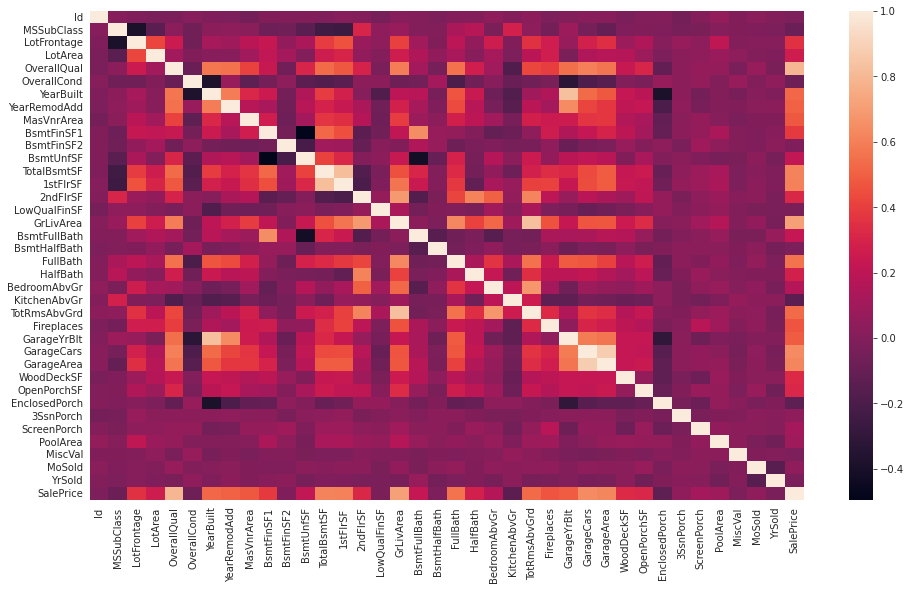

In [ ]:
# Let's check the correlation heatmap and see if our guesses are correct

corr = train_df.corr()
plt.figure(figsize=(16, 9))
sns.heatmap(corr, cmap='rocket')

In [ ]:
# Check the correlation

corr_ = corr['SalePrice'].sort_values(ascending=False)
corr_

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

Not all features are present in the correlation matrix, hence the remaining features are most certainly of different data types like categorical features.

In [ ]:
# Let's see how much data we actually have

print("Original train df: ", train_df.shape)
print("Original test df: ", test_df.shape)
print("X train shape: ", x_train.shape)
print("X test shape: ", x_test.shape)
print("y train shape: ", y_train.shape)
print("y test shape: ", y_test.shape)

Original train df:  (1460, 81)
Original test df:  (1459, 80)
X train shape:  (1168, 80)
X test shape:  (292, 80)
y train shape:  (1168,)
y test shape:  (292,)


In [ ]:
# Check the unique data types

print(x_train.dtypes.unique())

[dtype('int64') dtype('O') dtype('float64')]


We will only look at the train set and split it to obtain a validation set since the given test set does not come with labels and we won't be able to evaluate our model performance on that test set.

In [ ]:
# Split different dtypes into different Dataframe for easy viewing and analysis

x_train_df_int = x_train.select_dtypes(include='int64', exclude=['float64', 'object'])
x_train_df_float = x_train.select_dtypes(include='float64', exclude=['int64', 'object'])
x_train_df_obj = x_train.select_dtypes(include='object', exclude=['int64', 'float64'])

x_test_df_int = x_test.select_dtypes(include='int64', exclude=['float64', 'object'])
x_test_df_float = x_test.select_dtypes(include='float64', exclude=['int64', 'object'])
x_test_df_obj = x_test.select_dtypes(include='object', exclude=['int64', 'float64'])


In [ ]:
x_train_df_int.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1168.0,730.904966,425.369088,1.0,360.75,732.5,1101.75,1460.0
MSSubClass,1168.0,56.849315,42.531862,20.0,20.00,50.0,70.00,190.0
LotArea,1168.0,10689.642123,10759.366198,1300.0,7587.25,9600.0,11700.00,215245.0
OverallQual,1168.0,6.121575,1.367619,1.0,5.00,6.0,7.00,10.0
OverallCond,1168.0,5.584760,1.116062,1.0,5.00,5.0,6.00,9.0
YearBuilt,1168.0,1970.965753,30.675495,1872.0,1953.00,1972.0,2001.00,2010.0
YearRemodAdd,1168.0,1984.897260,20.733955,1950.0,1966.00,1994.0,2004.00,2010.0
BsmtFinSF1,1168.0,446.023973,459.070977,0.0,0.00,384.5,721.00,5644.0
BsmtFinSF2,1168.0,45.152397,158.217499,0.0,0.00,0.0,0.00,1127.0
BsmtUnfSF,1168.0,570.595034,446.364551,0.0,222.50,480.0,810.25,2336.0


In [ ]:
x_train_df_float.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LotFrontage,951.0,70.343849,24.897021,21.0,59.00,70.0,80.0,313.0
MasVnrArea,1162.0,103.771945,173.032238,0.0,0.00,0.0,166.0,1378.0
GarageYrBlt,1104.0,1978.662138,24.728938,1900.0,1961.75,1980.0,2002.0,2010.0


In [ ]:
x_train_df_obj.describe().transpose()

,count,unique,top,freq
MSZoning,1168,5,RL,924
Street,1168,2,Pave,1164
Alley,74,2,Grvl,44
LotShape,1168,4,Reg,729
LandContour,1168,4,Lvl,1059
Utilities,1168,2,AllPub,1167
LotConfig,1168,5,Inside,822
LandSlope,1168,3,Gtl,1108
Neighborhood,1168,25,NAmes,181
Condition1,1168,9,Norm,1004


Let's take a look at the plots of the top 10 most correlated feature against SalePrice

Text(0.5, 1.0, 'Overall Quality vs Sale Price')

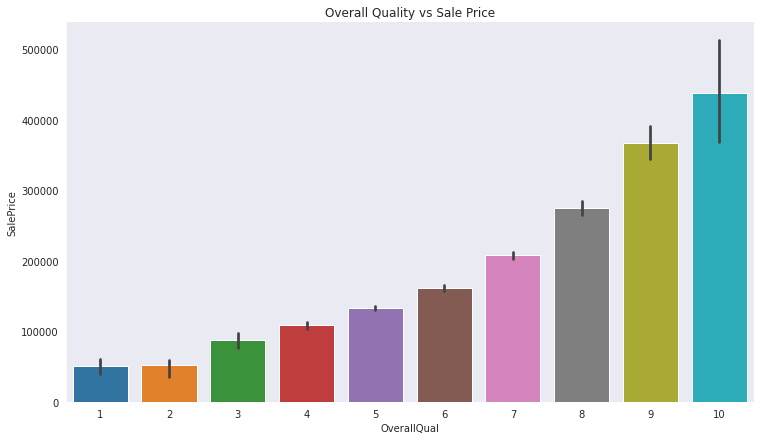

In [ ]:
# Plot OverallQual - SalePrice

sns.catplot(x='OverallQual', y='SalePrice', data=train_df, kind='bar', aspect=16/9, height=6)
plt.title("Overall Quality vs Sale Price")

The categorical plot makes sense as the higher the quality of the house, the higher the sale price.

Text(0.5, 1.0, 'GrLivArea vs Sale Price')

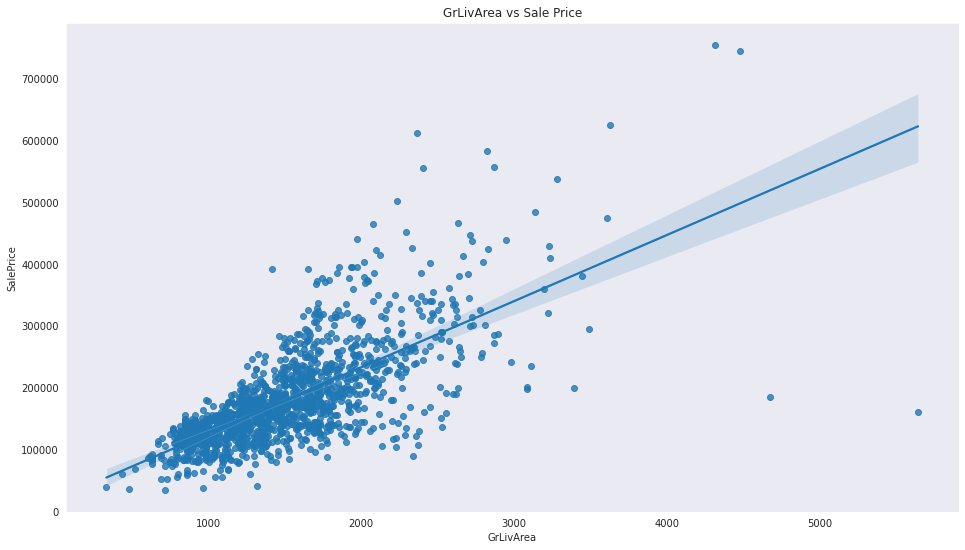

In [ ]:
# Plot GrLivArea - SalePrice

plt.figure(figsize=(16, 9))
sns.regplot(x='GrLivArea', y='SalePrice', data=train_df)
plt.title("GrLivArea vs Sale Price")

As with real estates, the larger the living area, the higher the price. But we can also see several outliers, specifically the two data points at the bottom right. One assumption for this low sale price despite the huge area is that this piece of land is of agricultural use. Or of some other less relevant use cases.

Text(0.5, 1.0, 'Capacity of Garage vs Sale Price')

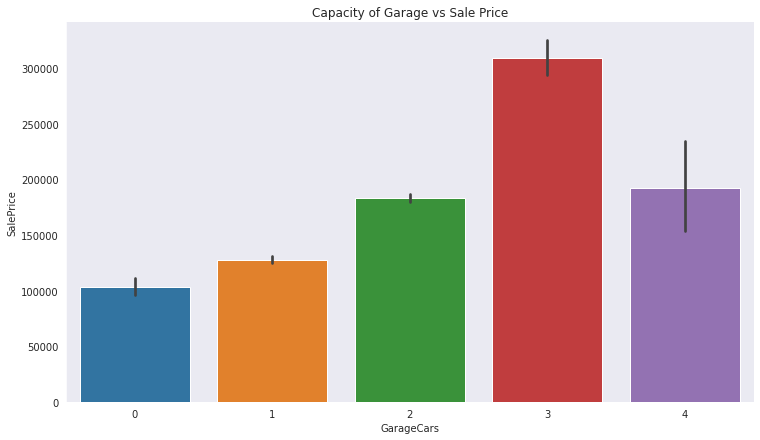

In [ ]:
# Plot GarageCars - SalePrice

sns.catplot(x='GarageCars', y='SalePrice', data=train_df, aspect=16/9, height=6, kind='bar')
plt.title("Capacity of Garage vs Sale Price")

Generally, this makes sense except the fact that houses with a garage that can store 4 cars are priced less than those that can store 3.

Text(0.5, 1.0, 'Garage Area vs Sale Price')

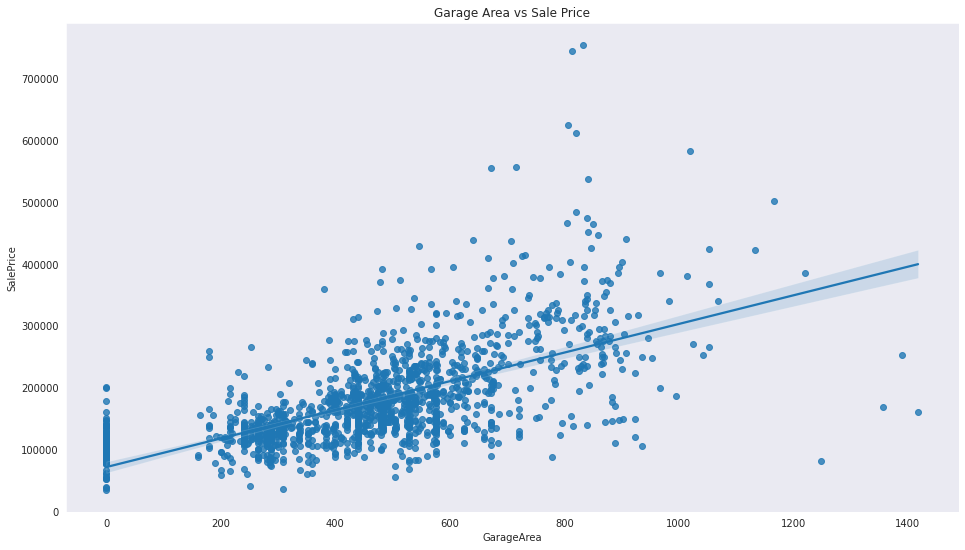

In [ ]:
# Plot GarageArea - SalePrice

plt.figure(figsize=(16, 9))
sns.regplot(x='GarageArea', y='SalePrice', data=train_df)
plt.title("Garage Area vs Sale Price")

GarageArea makes sense like how GrLivArea does, the bigger the area, the higher the sale price.

Text(0.5, 1.0, 'Total Basement Area (sqft) vs Sale Price')

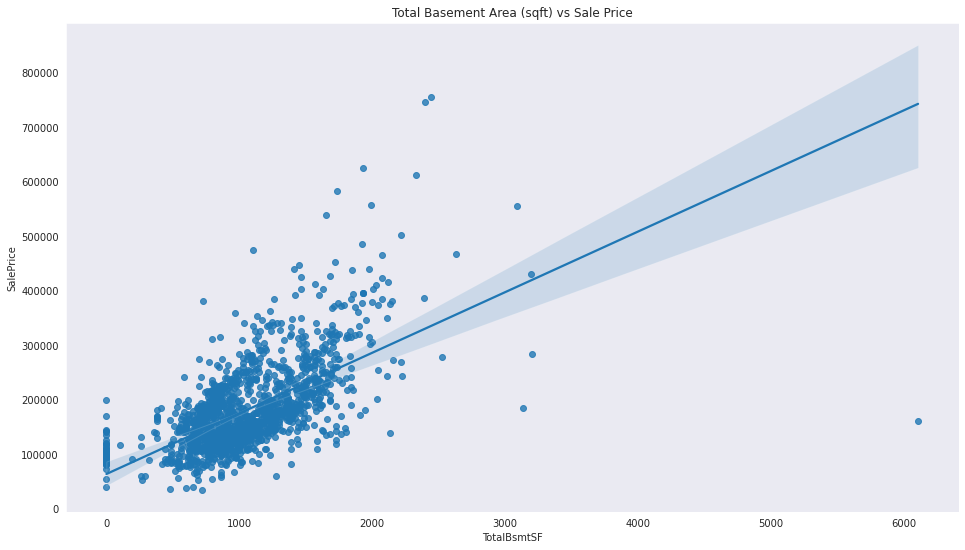

In [ ]:
# Plot TotalBsmtSF - SalePrice

plt.figure(figsize=(16, 9))
sns.regplot(x='TotalBsmtSF', y='SalePrice', data=train_df)
plt.title("Total Basement Area (sqft) vs Sale Price")

Clearly, there is an outlier where the total basement area is large but comes at a low sale price. It could be an error, we will deal with that later.

Text(0.5, 1.0, '1st Floor Area (sqft) vs Sale Price')

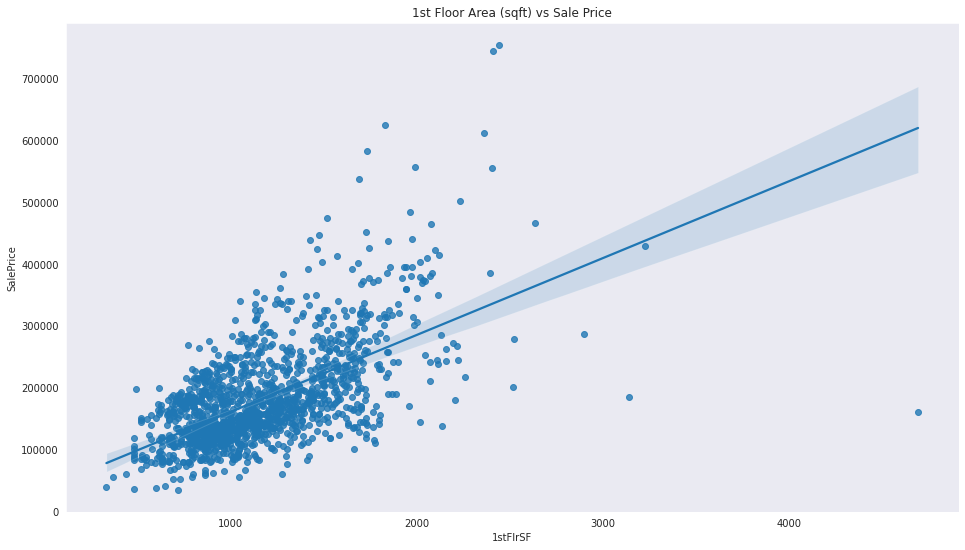

In [ ]:
# Plot 1stFlrSF - SalePrice

plt.figure(figsize=(16, 9))
sns.regplot(x='1stFlrSF', y='SalePrice', data=train_df)
plt.title("1st Floor Area (sqft) vs Sale Price")

Similar to the previous plot, the trend makes sense generally, but with an outlier too. Notice how the prices vary across bigger ranges when the areas get larger.

Text(0.5, 1.0, 'Number of Full Bathrooms vs Sale Price')

<Figure size 1152x648 with 0 Axes>

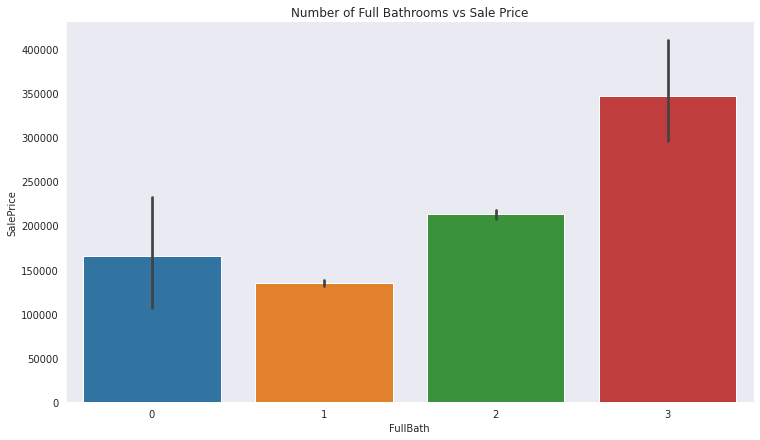

In [ ]:
# Plot FullBath - SalePrice

plt.figure(figsize=(16, 9))
sns.catplot(x='FullBath', y='SalePrice', data=train_df, kind='bar', height=6, aspect=16/9)
plt.title("Number of Full Bathrooms vs Sale Price")

Surprisingly, there are houses with 0 full bathrooms that are priced higher than those with 1 full bathroom. But the rest is still reasonable.

Text(0.5, 1.0, 'Total Rooms Above Grade vs Sale Price')

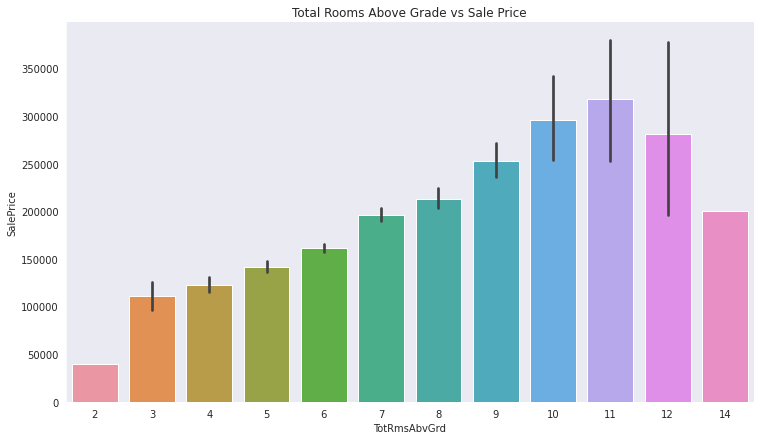

In [ ]:
# Plot TotRmsAbvGrd - SalePrice

sns.catplot(x='TotRmsAbvGrd', y='SalePrice', data=train_df, kind='bar', aspect=16/9, height=6)
plt.title("Total Rooms Above Grade vs Sale Price")

Again, it is slightly weird that houses with 12 and 14 rooms are priced lower than houses with 11 rooms and below. But overall, still a logical plot. Notice how the number 13 was skipped, it might be due to the taboo in the US which hates the number 13.

Text(0.5, 1.0, 'Year Built vs Sale Price')

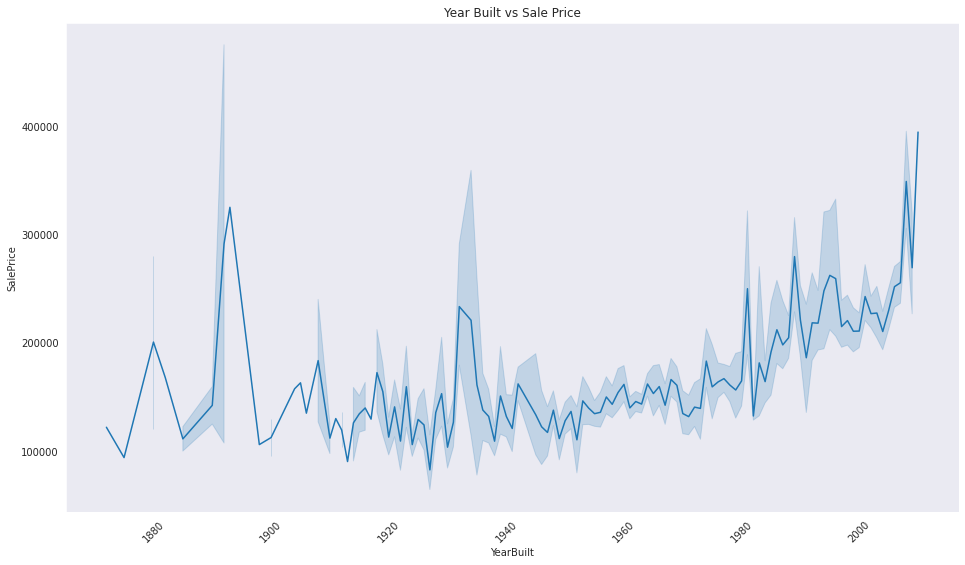

In [ ]:
# Plot YearBuilt - SalePrice

plt.figure(figsize=(16, 9))
sns.lineplot(x='YearBuilt', y='SalePrice', data=train_df)
plt.xticks(rotation=45)
plt.title("Year Built vs Sale Price")

Very clearly, the trend is rising, houses are getting more expensive each year.

Text(0.5, 1.0, 'Year Remodel Added vs Sale Price')

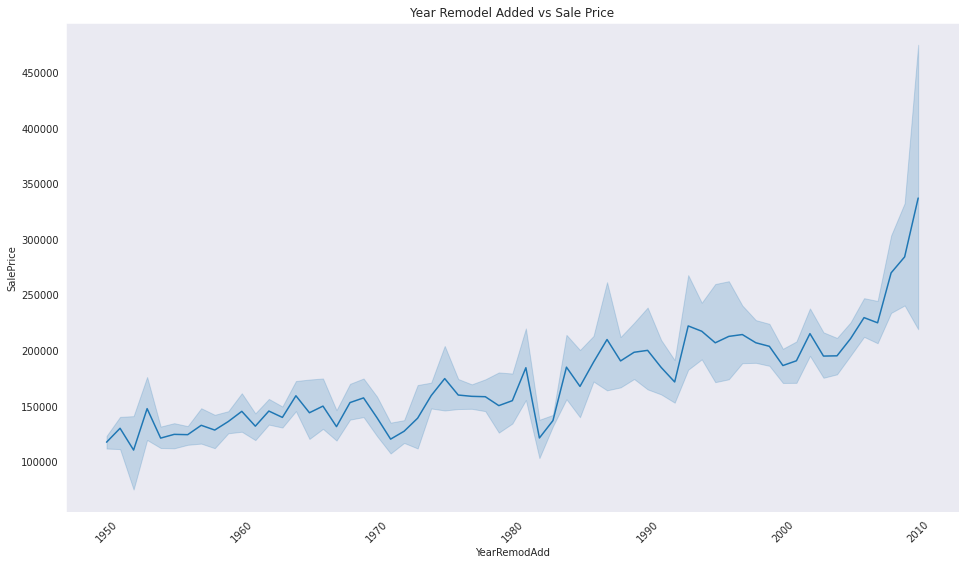

In [ ]:
# Plot YearRemodAdd - SalePrice

plt.figure(figsize=(16, 9))
sns.lineplot(x='YearRemodAdd', y='SalePrice', data=train_df)
plt.xticks(rotation=45)
plt.title("Year Remodel Added vs Sale Price")

A clearer trend than the YearBuilt, but YearRemodAdd shows that if the house goes through a remodelling, the higher value it gets. And the more recent it is, the higher the price too.

# Check missing data


In [ ]:
# Check missing data for integer data type for x_train_df_int
total_null = x_train_df_int.isnull().sum().sort_values(ascending=False)
percent_null = (x_train_df_int.isnull().sum() / x_train_df_int.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
missing_data

,Total,Percent


In [ ]:
# Check missing data for integer data type for x_test_df_int
total_null = x_test_df_int.isnull().sum().sort_values(ascending=False)
percent_null = (x_test_df_int.isnull().sum() / x_test_df_int.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
missing_data

,Total,Percent


In [ ]:
# Check missing data for float data type for x_train_df_float
total_null = x_train_df_float.isnull().sum().sort_values(ascending=False)
percent_null = (x_train_df_float.isnull().sum() / x_train_df_float.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
missing_data

,Total,Percent
LotFrontage,217,0.185788
GarageYrBlt,64,0.054795
MasVnrArea,6,0.005137


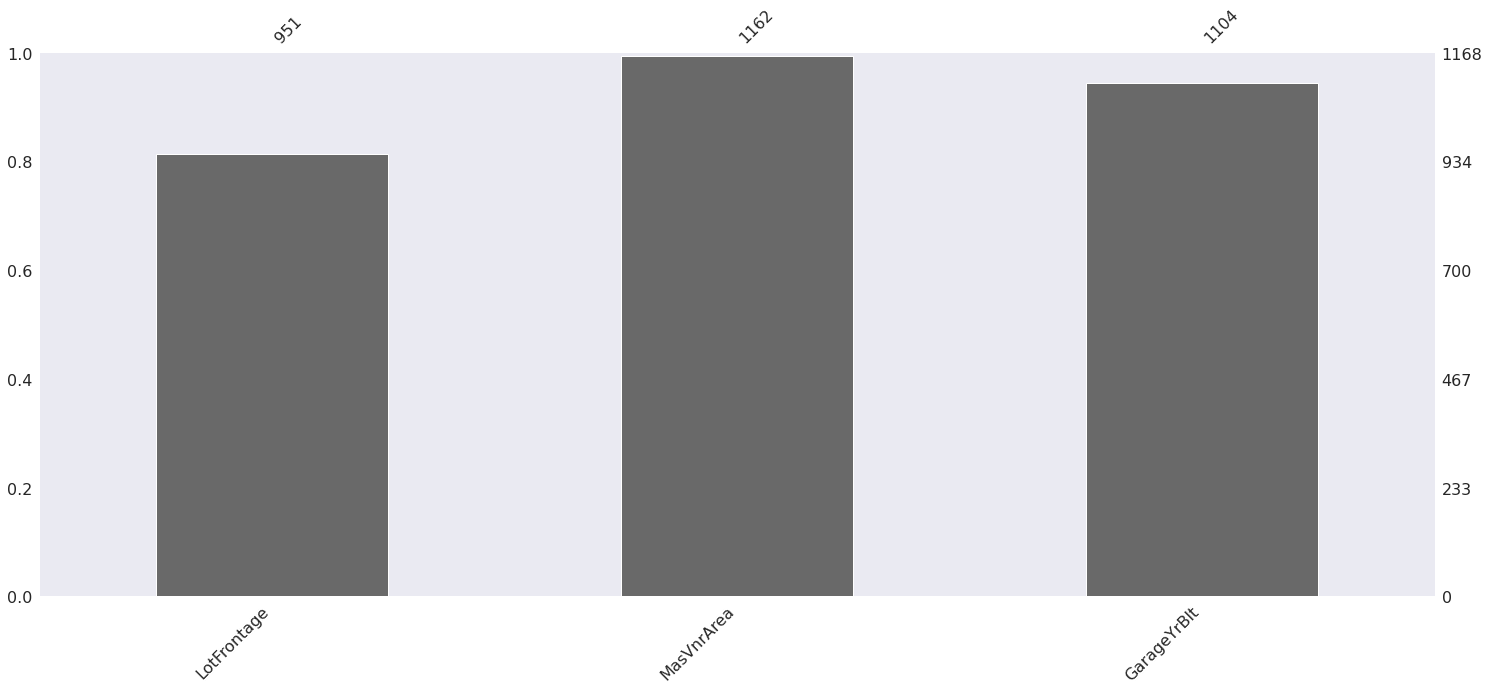

In [ ]:
# Plot it out to visualize better

plt.figure(figsize=(16, 9))
msno.bar(x_train_df_float)

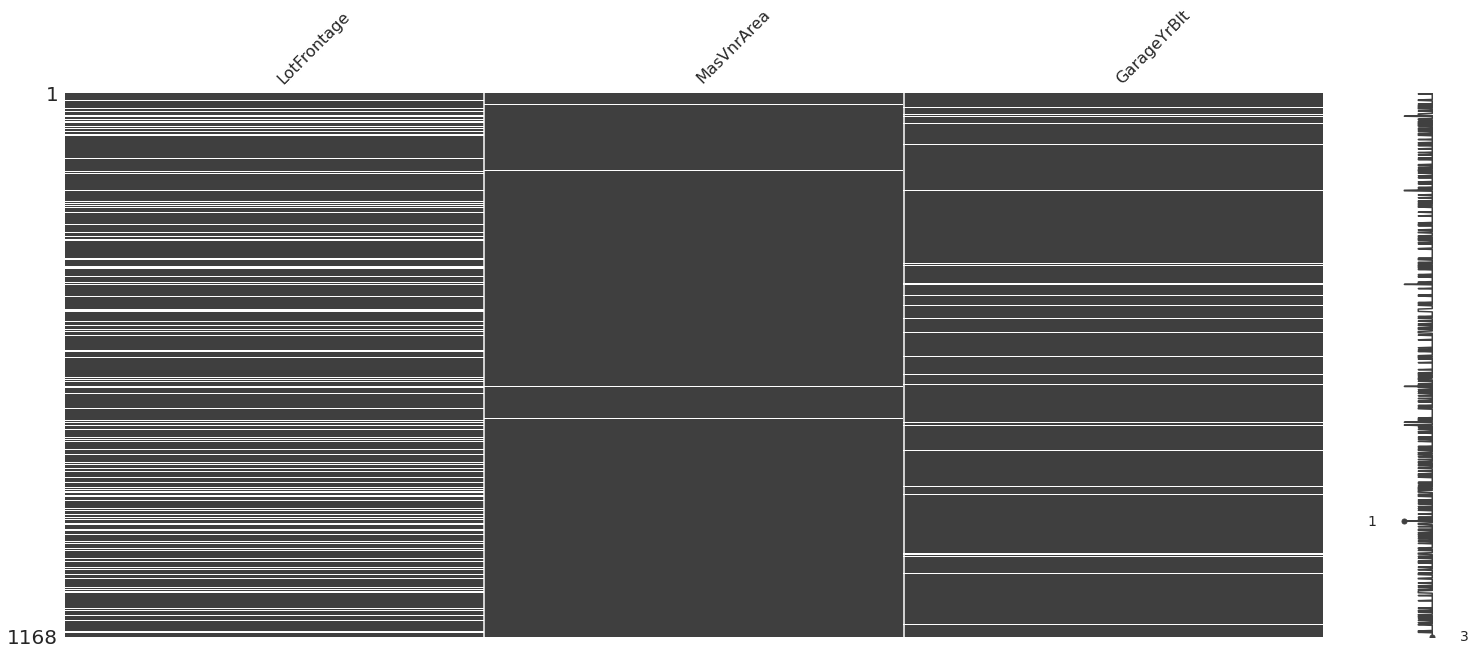

In [ ]:
msno.matrix(x_train_df_float)

Text(0.5, 1.0, 'Box plot of LotFrontage')

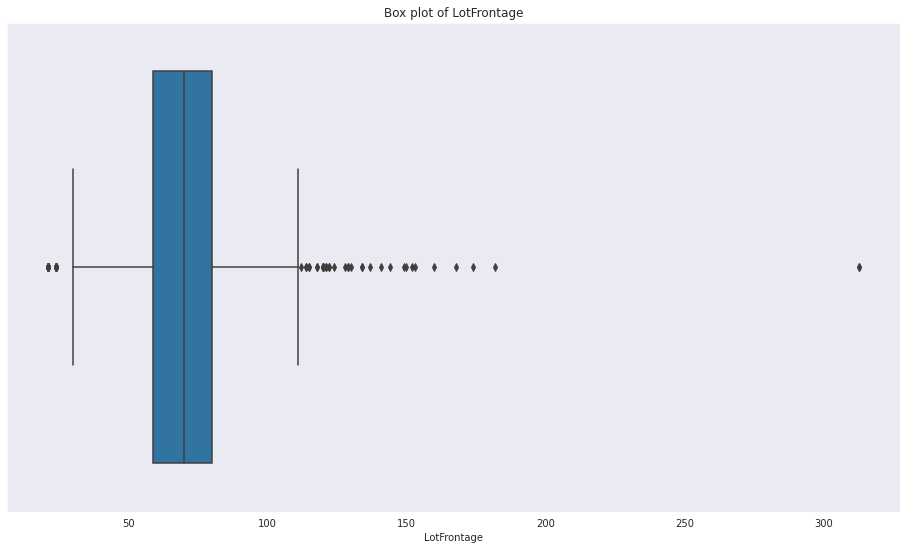

In [ ]:
# Plot the box plot to visualize the distribution and check for skewness before imputing
plt.figure(figsize=(16, 9))
sns.boxplot(x='LotFrontage', data=x_train_df_float)
plt.title("Box plot of LotFrontage")

Text(0.5, 1.0, 'Box plot of MasVnrArea')

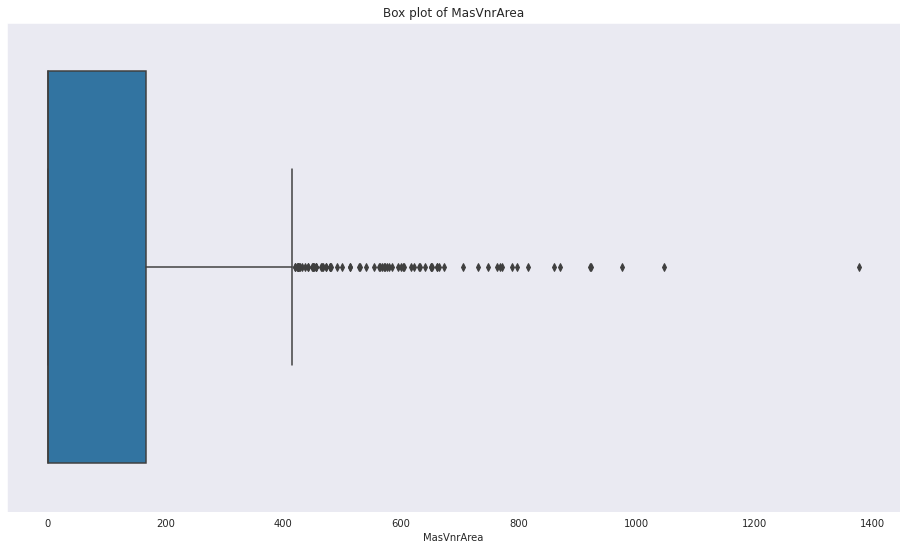

In [ ]:
plt.figure(figsize=(16, 9))
sns.boxplot(x='MasVnrArea', data=x_train_df_float)
plt.title("Box plot of MasVnrArea")

Text(0.5, 1.0, 'Box plot of GarageYrBlt')

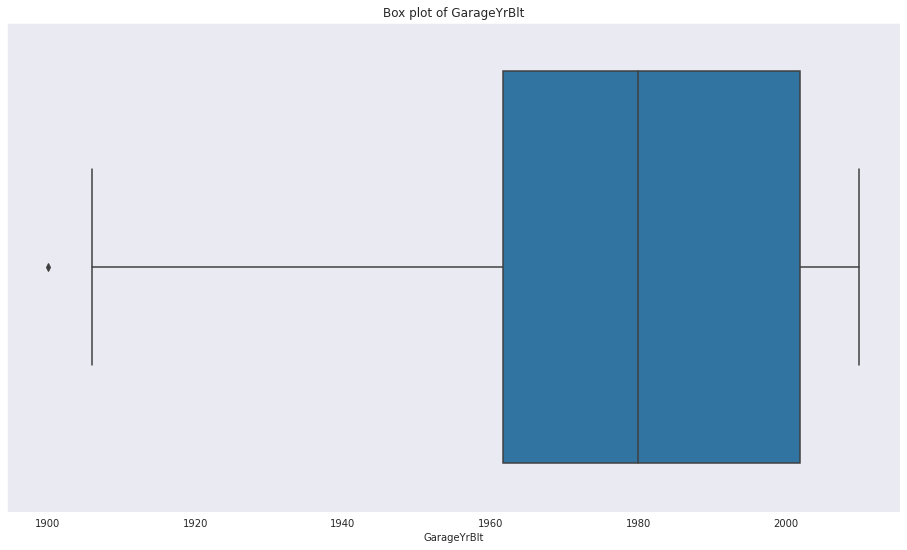

In [ ]:
plt.figure(figsize=(16, 9))
sns.boxplot(x='GarageYrBlt', data=x_train_df_float)
plt.title("Box plot of GarageYrBlt")

In [ ]:
# Before we impute, let's check for x_test_df_float
total_null = x_test_df_float.isnull().sum().sort_values(ascending=False)
percent_null = (x_test_df_float.isnull().sum() / x_test_df_float.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
missing_data

,Total,Percent
LotFrontage,42,0.143836
GarageYrBlt,17,0.058219
MasVnrArea,2,0.006849


Since the box plots are fine, we can use the median of the train set to impute the missing values. Plus the missing values are at random, so there is no set patterns to follow.

In [ ]:
# Impute with median of X_TRAIN_DF_FLOAT for both x_train_df_float and x_test_df_float

x_train_df_float['LotFrontage'].fillna(x_train_df_float['LotFrontage'].median(), inplace=True)
x_train_df_float['MasVnrArea'].fillna(x_train_df_float['MasVnrArea'].median(), inplace=True)
x_train_df_float['GarageYrBlt'].fillna(x_train_df_float['GarageYrBlt'].median(), inplace=True)

x_test_df_float['LotFrontage'].fillna(x_train_df_float['LotFrontage'].median(), inplace=True)
x_test_df_float['MasVnrArea'].fillna(x_train_df_float['MasVnrArea'].median(), inplace=True)
x_test_df_float['GarageYrBlt'].fillna(x_train_df_float['GarageYrBlt'].median(), inplace=True)

print(x_train_df_float.isnull().sum().max())
print(x_test_df_float.isnull().sum().max())


0
0


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
# Check missing data for obj/cat data type
total_null = x_train_df_obj.isnull().sum().sort_values(ascending=False)
percent_null = (x_train_df_obj.isnull().sum() / x_train_df_obj.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
print(missing_data.shape[0])
missing_data

16


,Total,Percent
PoolQC,1162,0.994863
MiscFeature,1122,0.960616
Alley,1094,0.936644
Fence,935,0.800514
FireplaceQu,547,0.468322
GarageCond,64,0.054795
GarageQual,64,0.054795
GarageFinish,64,0.054795
GarageType,64,0.054795
BsmtFinType2,28,0.023973


In [ ]:
# Check missing data for obj/cat data type
total_null = x_test_df_obj.isnull().sum().sort_values(ascending=False)
percent_null = (x_test_df_obj.isnull().sum() / x_test_df_obj.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
print(missing_data.shape[0])
missing_data

15


,Total,Percent
PoolQC,291,0.996575
MiscFeature,284,0.972603
Alley,275,0.941781
Fence,244,0.835616
FireplaceQu,143,0.489726
GarageCond,17,0.058219
GarageQual,17,0.058219
GarageFinish,17,0.058219
GarageType,17,0.058219
BsmtFinType2,10,0.034247


The top 5 attributes have more than 40% missing data, with the top 3 having more than 80%. So it's okay to drop them rather than impute with such few data.

In [ ]:
# Since the top 5 attributes with missing data have more than 40% missing values, it's okay to drop these attributes
x_train_df_obj.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], inplace=True, axis=1)
x_test_df_obj.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], inplace=True, axis=1)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The features for Garage_ and Bsmt_ seem to have similar number of missing values, we can safely assume that the houses associated with the index do not come with those features. Or it could have also been an entry error. But either way, we can impute with one of the category of the feature - NA (No Garage/No Basement)

In [ ]:
# For the features starting with 'Garage_', we can impute with NA
print("Before: ", x_train_df_obj['GarageCond'].isnull().sum())
x_train_df_obj['GarageCond'].fillna('NA', inplace=True)
x_train_df_obj['GarageQual'].fillna('NA', inplace=True)
x_train_df_obj['GarageFinish'].fillna('NA', inplace=True)
x_train_df_obj['GarageType'].fillna('NA', inplace=True)
print("After: ", x_train_df_obj['GarageCond'].isnull().sum())

# For test set
print("Before: ", x_test_df_obj['GarageCond'].isnull().sum())
x_test_df_obj['GarageCond'].fillna('NA', inplace=True)
x_test_df_obj['GarageQual'].fillna('NA', inplace=True)
x_test_df_obj['GarageFinish'].fillna('NA', inplace=True)
x_test_df_obj['GarageType'].fillna('NA', inplace=True)
print("After: ", x_test_df_obj['GarageCond'].isnull().sum())

Before:  64
After:  0
Before:  17
After:  0


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
# For the features starting with 'Bsmt_', we can impute with NA
print("Before: ", x_train_df_obj['BsmtQual'].isnull().sum())
x_train_df_obj['BsmtFinType2'].fillna('NA', inplace=True)
x_train_df_obj['BsmtExposure'].fillna('NA', inplace=True)
x_train_df_obj['BsmtFinType1'].fillna('NA', inplace=True)
x_train_df_obj['BsmtQual'].fillna('NA', inplace=True)
x_train_df_obj['BsmtCond'].fillna('NA', inplace=True)
print("After: ", x_train_df_obj['BsmtQual'].isnull().sum())

# For test set
print("Before: ", x_test_df_obj['BsmtQual'].isnull().sum())
x_test_df_obj['BsmtFinType2'].fillna('NA', inplace=True)
x_test_df_obj['BsmtExposure'].fillna('NA', inplace=True)
x_test_df_obj['BsmtFinType1'].fillna('NA', inplace=True)
x_test_df_obj['BsmtQual'].fillna('NA', inplace=True)
x_test_df_obj['BsmtCond'].fillna('NA', inplace=True)
print("After: ", x_test_df_obj['BsmtQual'].isnull().sum())

Before:  28
After:  0
Before:  9
After:  0


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
x_train_df_obj['MasVnrType'].value_counts()

None       677
BrkFace    366
Stone      106
BrkCmn      13
Name: MasVnrType, dtype: int64

In [ ]:
x_test_df_obj['MasVnrType'].value_counts()

None       187
BrkFace     79
Stone       22
BrkCmn       2
Name: MasVnrType, dtype: int64

In [ ]:
x_train_df_obj['Electrical'].value_counts()

SBrkr    1071
FuseA      69
FuseF      24
FuseP       3
Name: Electrical, dtype: int64

In [ ]:
x_test_df_obj['Electrical'].value_counts()

SBrkr    263
FuseA     25
FuseF      3
Mix        1
Name: Electrical, dtype: int64

After checking the value distribution, we can safely impute the two remaining features with their mode.

In [ ]:
# We will impute these two with the mode
x_train_df_obj['MasVnrType'].fillna(x_train_df_obj['MasVnrType'].mode()[0], inplace=True)
x_train_df_obj['Electrical'].fillna(x_train_df_obj['Electrical'].mode()[0], inplace=True)

# For test set
x_test_df_obj['MasVnrType'].fillna(x_train_df_obj['MasVnrType'].mode()[0], inplace=True)
x_test_df_obj['Electrical'].fillna(x_train_df_obj['Electrical'].mode()[0], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
# Check if there is any missing data for x_train_df_obj
total_null = x_train_df_obj.isnull().sum().sort_values(ascending=False)
percent_null = (x_train_df_obj.isnull().sum() / x_train_df_obj.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
missing_data

,Total,Percent


In [ ]:
# For test set
total_null = x_test_df_obj.isnull().sum().sort_values(ascending=False)
percent_null = (x_test_df_obj.isnull().sum() / x_test_df_obj.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
missing_data

,Total,Percent




---



# Check skewness

In [ ]:
# Combine the int and float data types to form a numerical feature dataframe
x_train_df_numeric = pd.concat([x_train_df_int, x_train_df_float], axis=1)

In [ ]:
x_test_df_numeric = pd.concat([x_test_df_int, x_test_df_float], axis=1)

In [ ]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in x_train_df_numeric.columns:
    if x_train_df_numeric[i].dtype in numeric_dtypes:
        numeric.append(i)

numeric

['Id',
 'MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'LotFrontage',
 'MasVnrArea',
 'GarageYrBlt']

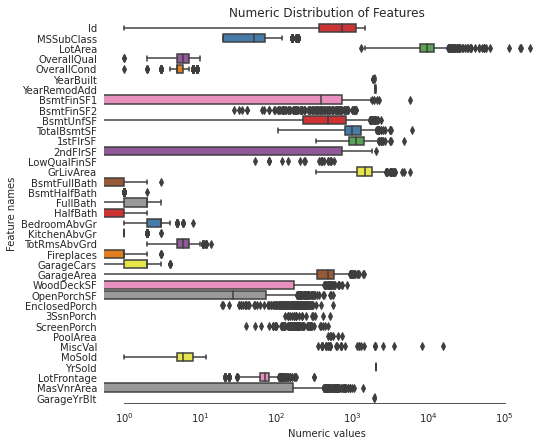

In [ ]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=x_train_df_numeric[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

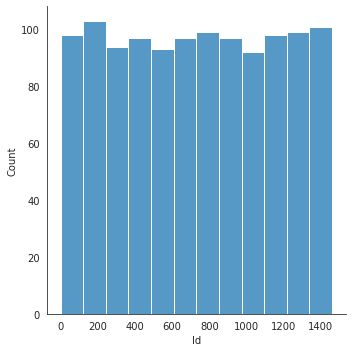

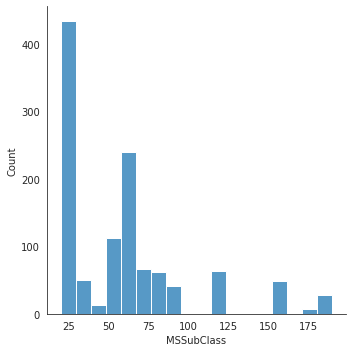

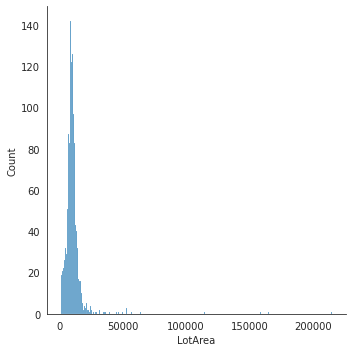

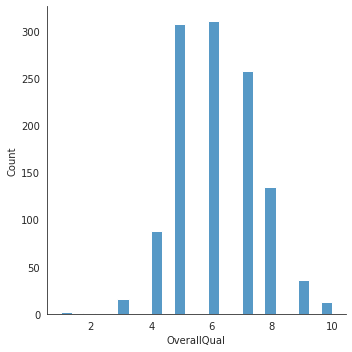

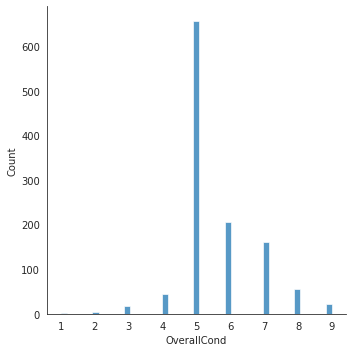

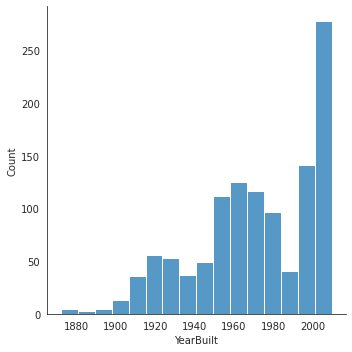

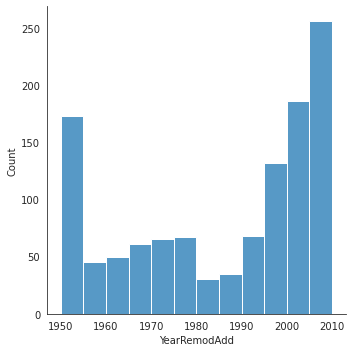

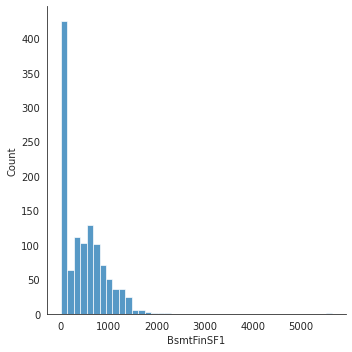

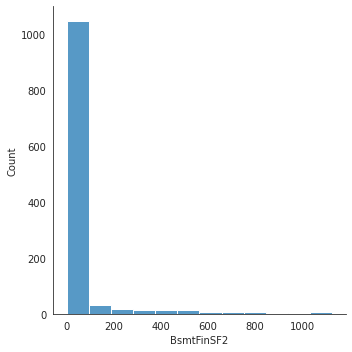

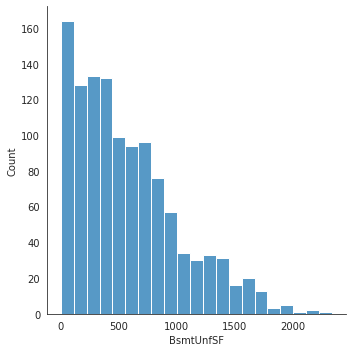

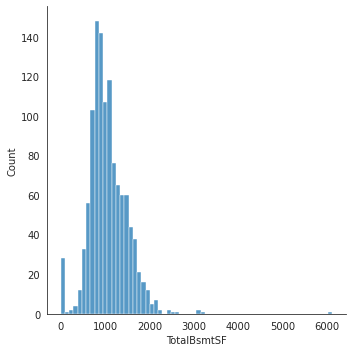

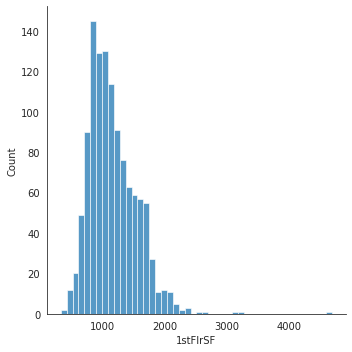

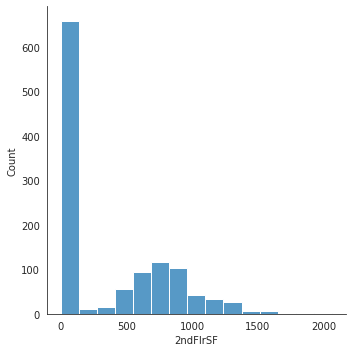

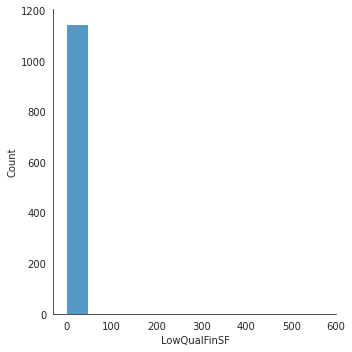

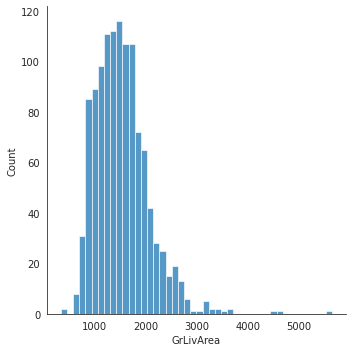

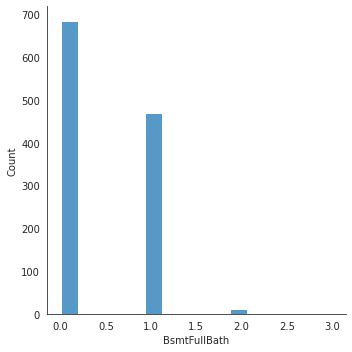

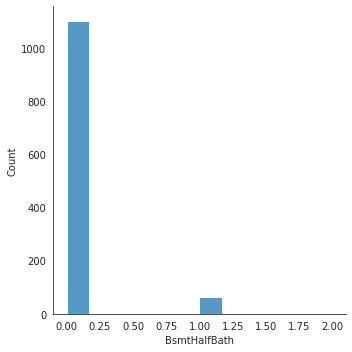

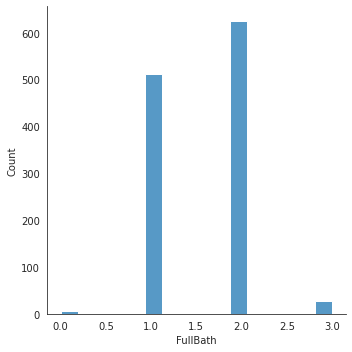

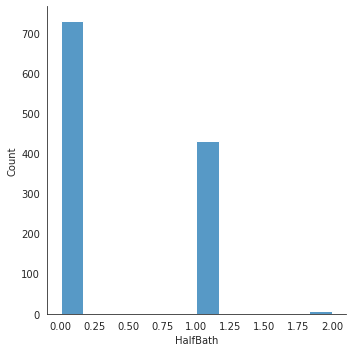

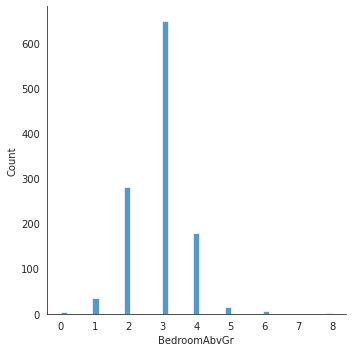

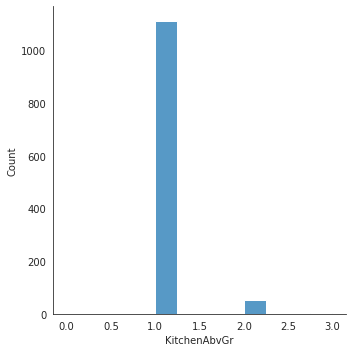

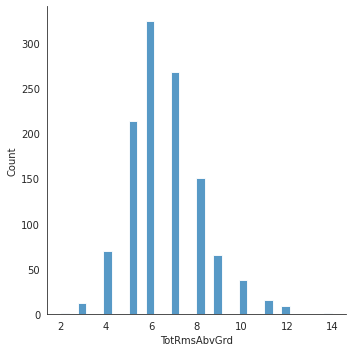

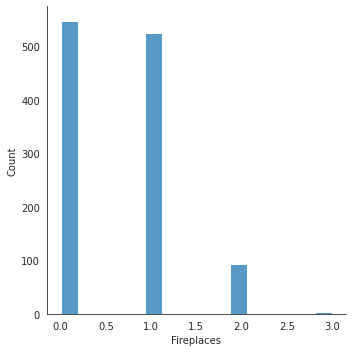

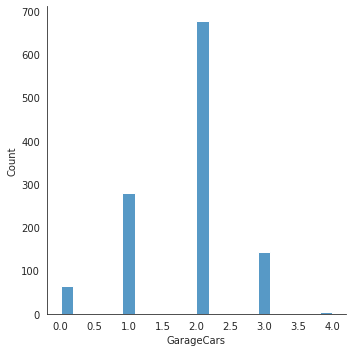

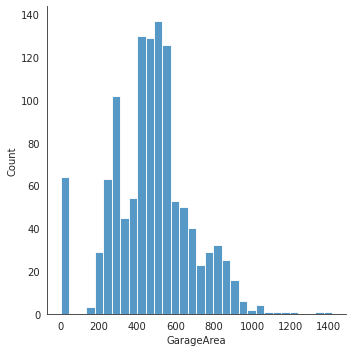

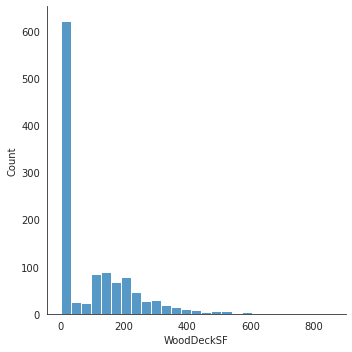

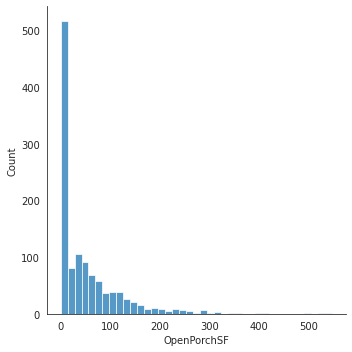

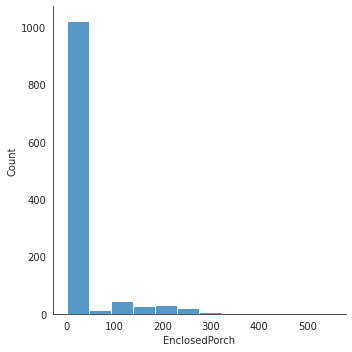

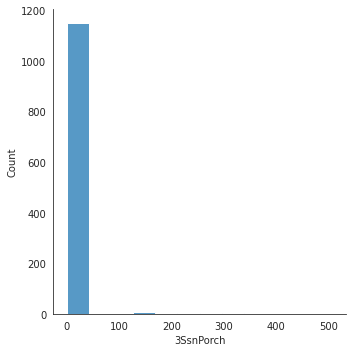

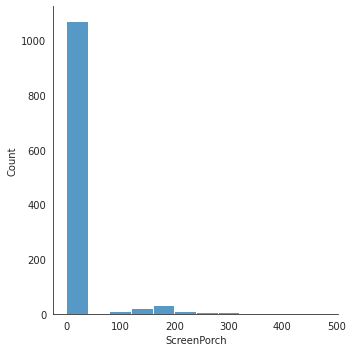

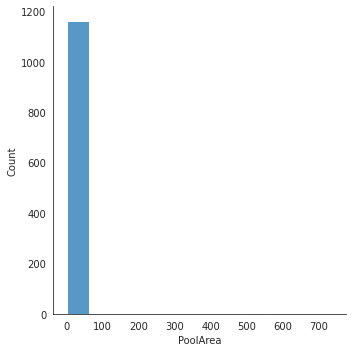

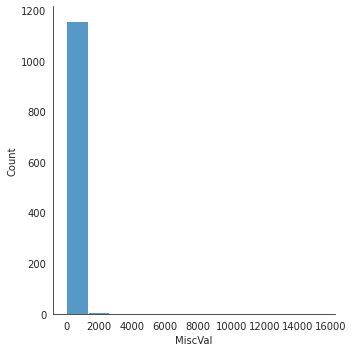

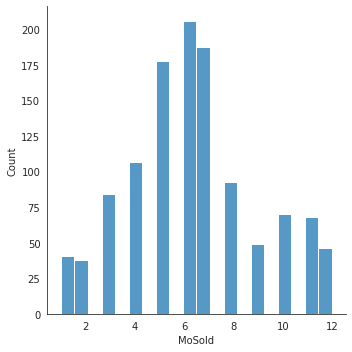

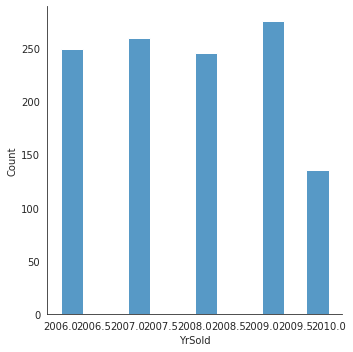

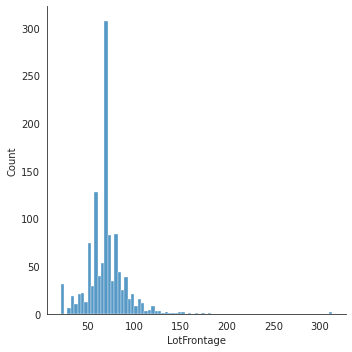

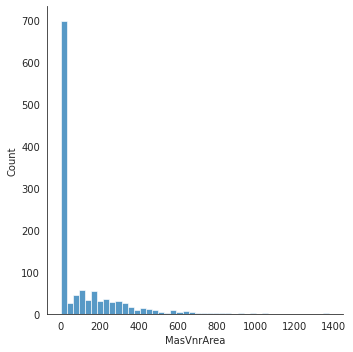

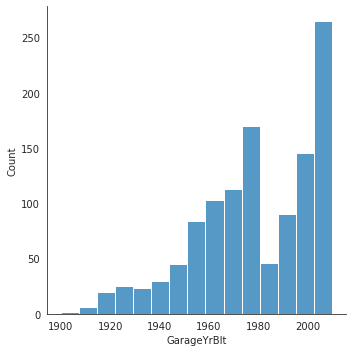

In [ ]:
# Checking for skewness
numerical_features=[feature for feature in x_train_df_numeric.columns if x_train_df_numeric[feature].dtypes!='object']
for feature in numerical_features:
    if feature=='SalePrice':
        pass
    else:
        # x_train_df_numeric[feature].hist()
        sns.displot(x_train_df_numeric[feature])
        plt.xlabel(feature)
        plt.show()

In [ ]:
# Find skewed numerical features
skew_features = x_train_df_numeric[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features

There are 26 numerical features with Skew > 0.5 :


MiscVal          22.025247
PoolArea         14.377604
LotArea          11.942726
3SsnPorch         9.821277
LowQualFinSF      9.187637
KitchenAbvGr      4.439345
BsmtFinSF2        4.212476
ScreenPorch       4.085138
BsmtHalfBath      4.000640
EnclosedPorch     3.159881
LotFrontage       2.671465
OpenPorchSF       2.328895
MasVnrArea        2.291170
BsmtFinSF1        1.859740
TotalBsmtSF       1.721666
WoodDeckSF        1.585291
MSSubClass        1.436955
GrLivArea         1.423308
1stFlrSF          1.420335
BsmtUnfSF         0.909458
2ndFlrSF          0.800180
OverallCond       0.732238
TotRmsAbvGrd      0.686453
HalfBath          0.650459
Fireplaces        0.636707
BsmtFullBath      0.611246
BedroomAbvGr      0.289510
MoSold            0.241450
OverallQual       0.196322
GarageArea        0.108970
YrSold            0.082486
FullBath          0.038120
Id                0.000919
GarageCars       -0.389231
YearRemodAdd     -0.507414
YearBuilt        -0.622603
GarageYrBlt      -0.693580
d

We pick features with high skewness (> 0.5) and perform log transformation. Log transformation is the most commonly used method to fix skewness since we would not want to have a model that would be biased. 

Numpy Log1p here the logarithm of 1 + input, hence we are able to input values of 0.

In [ ]:
# Log transform both the train and test set for the same features with high skewness

for i in skew_index:
  x_train_df_numeric[i] = np.log1p(x_train_df_numeric[i])
  x_test_df_numeric[i] = np.log1p(x_test_df_numeric[i])

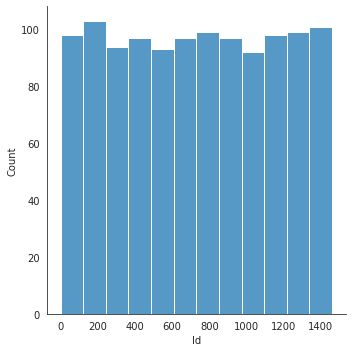

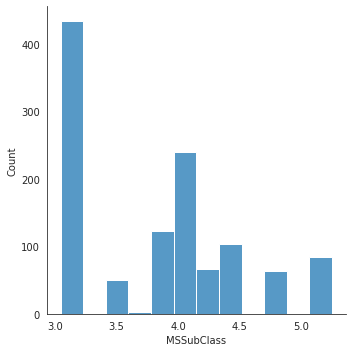

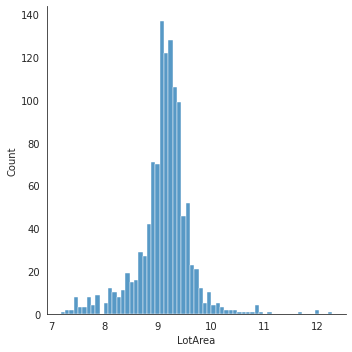

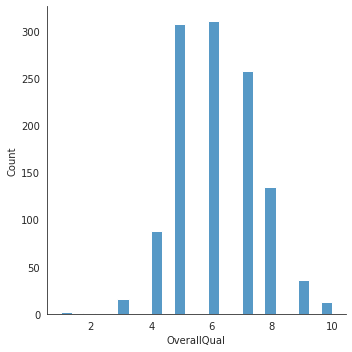

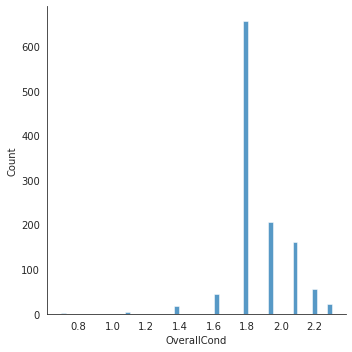

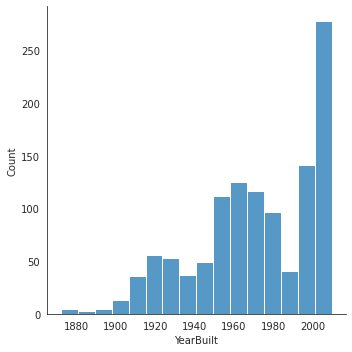

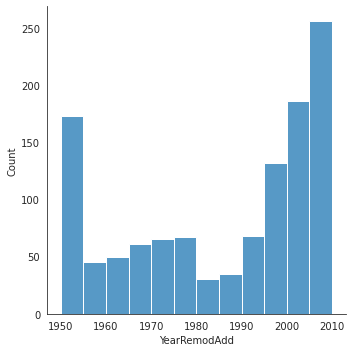

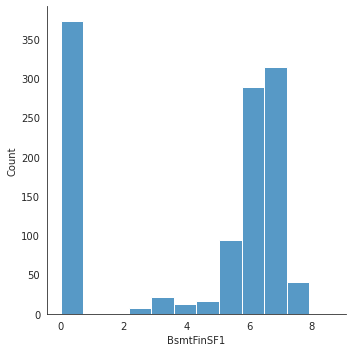

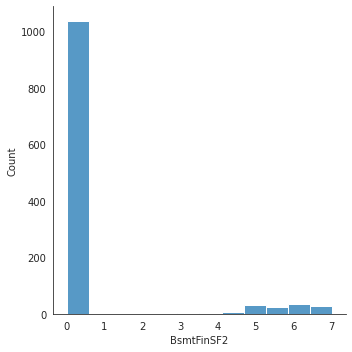

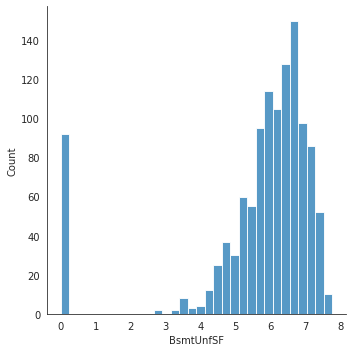

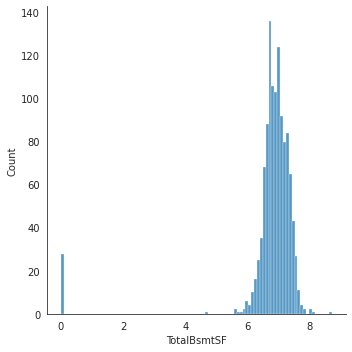

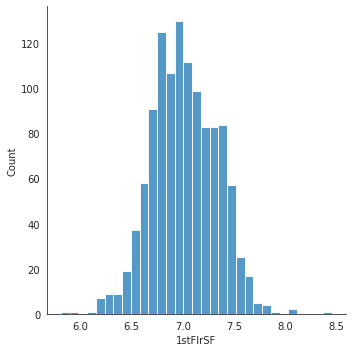

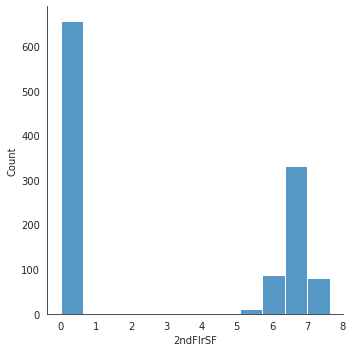

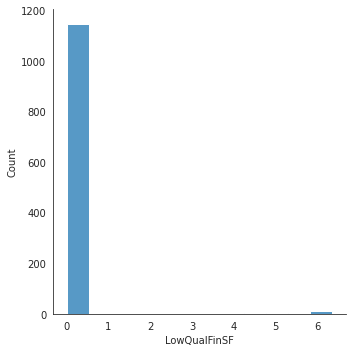

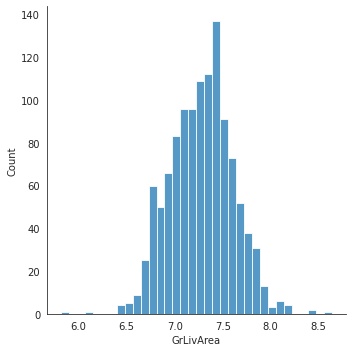

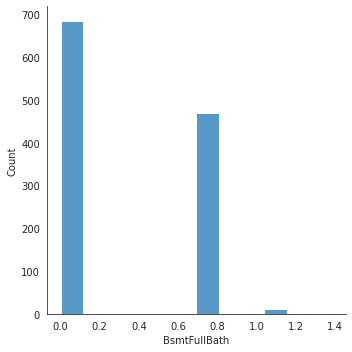

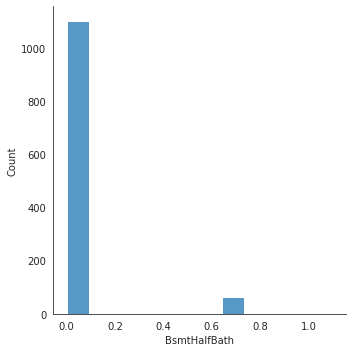

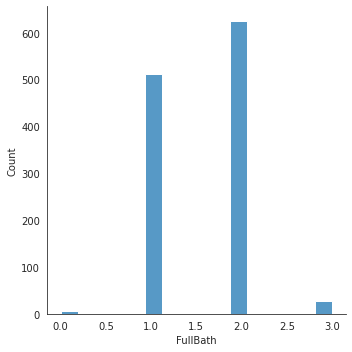

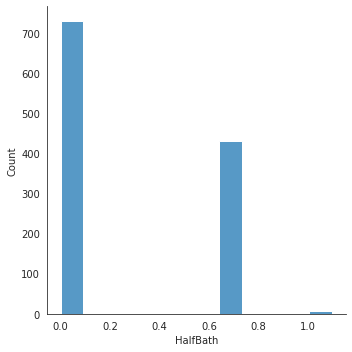

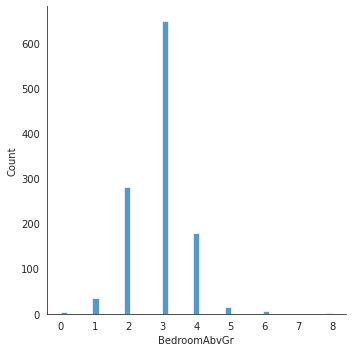

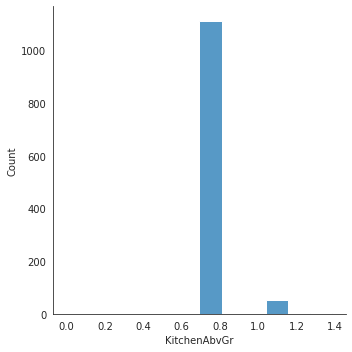

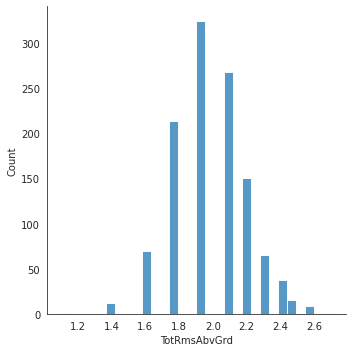

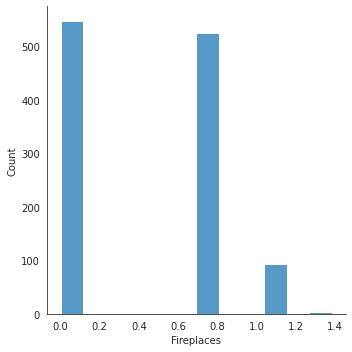

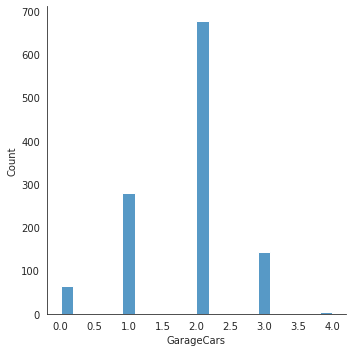

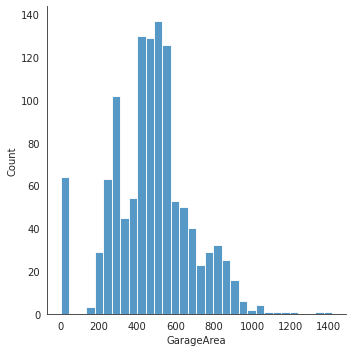

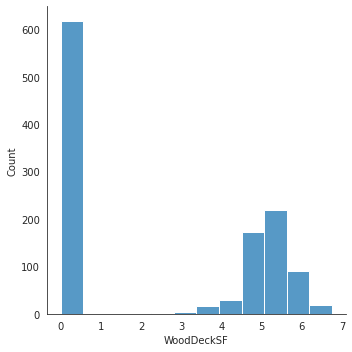

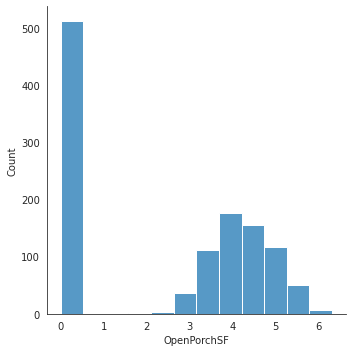

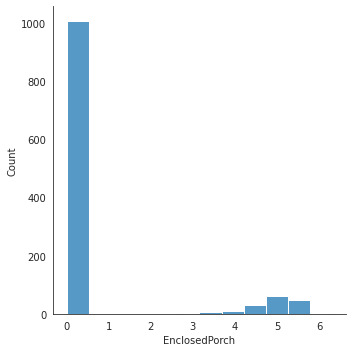

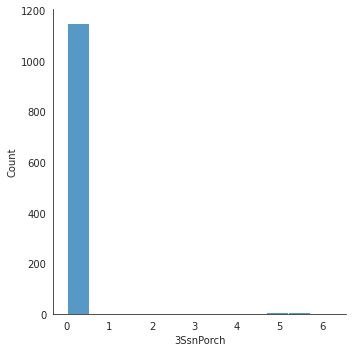

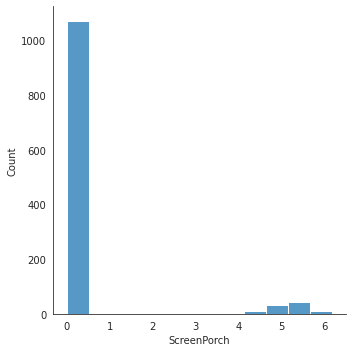

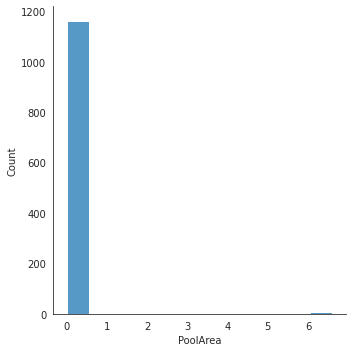

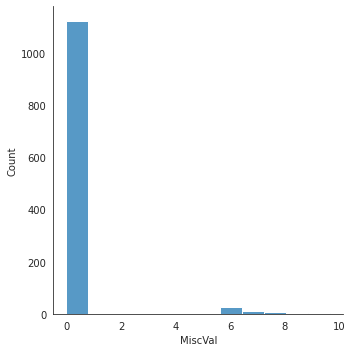

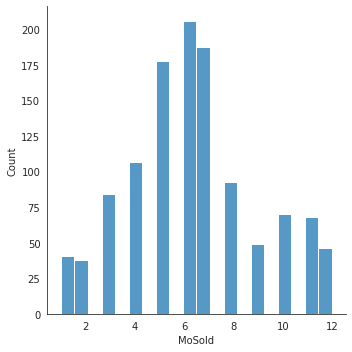

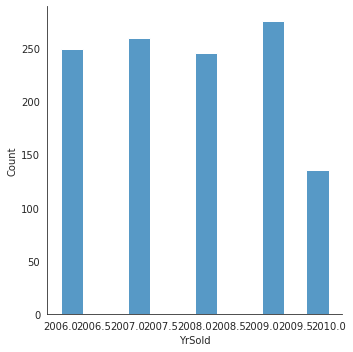

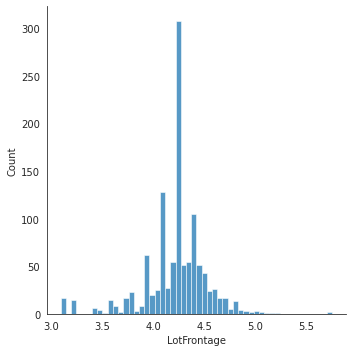

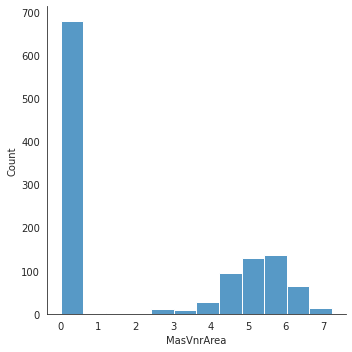

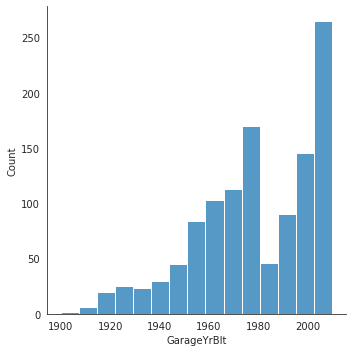

In [ ]:
# Checking for skewness
numerical_features=[feature for feature in x_train_df_numeric.columns if x_train_df_numeric[feature].dtypes!='object']
for feature in numerical_features:
    if feature=='SalePrice':
        pass
    else:
        # x_train_df_numeric[feature].hist()
        sns.displot(x_train_df_numeric[feature])
        plt.xlabel(feature)
        plt.show()

Checking our target variable, there is also a little skewness in the data, hence log transformation is applied to the SalePrice column

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


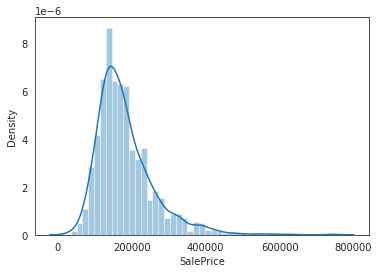

In [ ]:
# Check the SalePrice skewness

sns.distplot(y_train)
plt.show()

In [ ]:
# Fix the skewness by applying log transformation too
y_train = np.log1p(y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


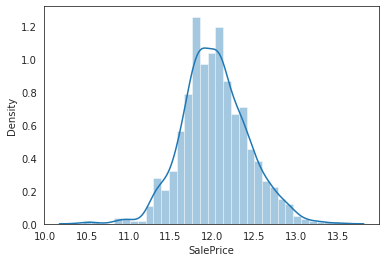

In [ ]:
# Check the SalePrice skewness

sns.distplot(y_train)
plt.show()

# Select features

If we notice from the data exploration stage previously, there is quite a number of features that have a lot of values of 0. Here we select features that do not contain mostly 0, a threshold of 30% is set and from here we are able to reduce our dimensions.

In [ ]:
# Check if there are features with values 0 30% of the time
feature_zero_ratio = {feature:x_train_df_numeric.loc[x_train_df_numeric[feature] == 0, feature].count() / 1460 for feature in x_train_df_numeric.columns.values}
feature_zero_ratio

{'1stFlrSF': 0.0,
 '2ndFlrSF': 0.45,
 '3SsnPorch': 0.7863013698630137,
 'BedroomAbvGr': 0.0027397260273972603,
 'BsmtFinSF1': 0.2554794520547945,
 'BsmtFinSF2': 0.7102739726027397,
 'BsmtFullBath': 0.4691780821917808,
 'BsmtHalfBath': 0.7547945205479452,
 'BsmtUnfSF': 0.06301369863013699,
 'EnclosedPorch': 0.6904109589041096,
 'Fireplaces': 0.37465753424657533,
 'FullBath': 0.003424657534246575,
 'GarageArea': 0.043835616438356165,
 'GarageCars': 0.043835616438356165,
 'GarageYrBlt': 0.0,
 'GrLivArea': 0.0,
 'HalfBath': 0.5,
 'Id': 0.0,
 'KitchenAbvGr': 0.0006849315068493151,
 'LotArea': 0.0,
 'LotFrontage': 0.0,
 'LowQualFinSF': 0.7856164383561643,
 'MSSubClass': 0.0,
 'MasVnrArea': 0.4657534246575342,
 'MiscVal': 0.7698630136986301,
 'MoSold': 0.0,
 'OpenPorchSF': 0.3506849315068493,
 'OverallCond': 0.0,
 'OverallQual': 0.0,
 'PoolArea': 0.7958904109589041,
 'ScreenPorch': 0.7335616438356164,
 'TotRmsAbvGrd': 0.0,
 'TotalBsmtSF': 0.019178082191780823,
 'WoodDeckSF': 0.423287671232876

In [ ]:
x_train_df_obj.shape

(1168, 38)

In [ ]:
x_train_df_numeric.shape

(1168, 37)

In [ ]:
# Drop the features with more than 30% 0 value
for feature in x_train_df_numeric:
    if feature_zero_ratio[feature] > 0.30:
        x_train_df_numeric = x_train_df_numeric.drop([feature], axis=1)

x_train_df_numeric.shape

(1168, 22)

In [ ]:
x_train_df_numeric.columns

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'MoSold', 'YrSold',
       'LotFrontage', 'GarageYrBlt'],
      dtype='object')

In [ ]:
y_train.shape

(1168,)

Checking the correlation values to see if imputing the missing data and dropping some features would result in a change in the order. But it seems to stay the same.

In [ ]:
# Check the correlation again and select features
temp_x_train_df_numeric = pd.concat([x_train_df_numeric, y_train], axis=1)
corr_n = temp_x_train_df_numeric.corr()
corr_n_ = corr_n.sort_values(by='SalePrice', ascending=False)
corr_n_['SalePrice']

SalePrice       1.000000
OverallQual     0.807946
GrLivArea       0.723567
GarageCars      0.684451
GarageArea      0.654520
1stFlrSF        0.595208
FullBath        0.583747
YearBuilt       0.576725
YearRemodAdd    0.562152
TotRmsAbvGrd    0.527405
GarageYrBlt     0.481453
LotArea         0.411305
TotalBsmtSF     0.379721
LotFrontage     0.328438
BsmtUnfSF       0.229778
BedroomAbvGr    0.193340
BsmtFinSF1      0.175344
MoSold          0.055651
OverallCond    -0.001640
Id             -0.015302
YrSold         -0.018459
MSSubClass     -0.023700
KitchenAbvGr   -0.153404
Name: SalePrice, dtype: float64

In [ ]:
corr_n_abs = abs(corr_n_['SalePrice'])
corr_n_abs

SalePrice       1.000000
OverallQual     0.807946
GrLivArea       0.723567
GarageCars      0.684451
GarageArea      0.654520
1stFlrSF        0.595208
FullBath        0.583747
YearBuilt       0.576725
YearRemodAdd    0.562152
TotRmsAbvGrd    0.527405
GarageYrBlt     0.481453
LotArea         0.411305
TotalBsmtSF     0.379721
LotFrontage     0.328438
BsmtUnfSF       0.229778
BedroomAbvGr    0.193340
BsmtFinSF1      0.175344
MoSold          0.055651
OverallCond     0.001640
Id              0.015302
YrSold          0.018459
MSSubClass      0.023700
KitchenAbvGr    0.153404
Name: SalePrice, dtype: float64

But we obtain the absolute value of the correlation coefficients and select features with coefficients greater than 0.2 to further reduce our dimensions.

In [ ]:
# Select correlation higher than 0.2 and keep the rest of the features in another dataframe
selected_features = list(corr_n_abs[corr_n_abs > 0.2].index.values)
selected_features

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 '1stFlrSF',
 'FullBath',
 'YearBuilt',
 'YearRemodAdd',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'LotArea',
 'TotalBsmtSF',
 'LotFrontage',
 'BsmtUnfSF']

In [ ]:
# Store the ID first
x_train_id = x_train_df_numeric['Id']
x_train_id

254      255
1066    1067
638      639
799      800
380      381
        ... 
1095    1096
1130    1131
1294    1295
860      861
1126    1127
Name: Id, Length: 1168, dtype: int64

In [ ]:
# Reduce our features by selecting the features we have chosen
selected_features.remove('SalePrice')
x_train_df_numeric_final = x_train_df_numeric[selected_features]
x_train_df_numeric_final

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF
254,5,7.181592,1,294,7.181592,1,1957,1957,1.791759,1957.0,9.036106,7.181592,4.262680,5.973810
1066,6,7.360104,2,380,6.684612,2,1993,1994,2.079442,1993.0,8.966739,6.684612,4.094345,6.684612
638,5,6.680855,0,0,6.680855,1,1910,1950,1.609438,1980.0,9.080004,6.680855,4.219508,6.680855
799,5,7.478170,1,240,6.889591,1,1937,1950,2.079442,1939.0,8.881975,6.595781,4.110874,5.093750
380,5,7.433667,1,308,6.934397,2,1924,1950,1.945910,1924.0,8.517393,6.934397,3.931826,6.695799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,6,7.181592,2,440,7.181592,2,2006,2006,1.945910,2006.0,9.139703,7.181592,4.369448,7.163172
1130,4,7.591862,2,576,7.192182,2,1928,1950,2.079442,1981.0,8.962520,7.023759,4.189655,6.216606
1294,5,6.762730,2,572,6.762730,1,1955,1990,1.791759,1957.0,9.008591,6.762730,4.110874,6.548219
860,7,7.263330,1,216,6.816736,1,1918,1998,2.079442,1925.0,8.941545,6.816736,4.025352,6.816736


In [ ]:
# Check the x_test
x_test_df_numeric_final = x_test_df_numeric[selected_features]
x_test_df_numeric_final

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF
892,6,6.974479,1,264,6.974479,1,1963,2003,1.945910,1963.0,9.037771,6.966024,4.262680,5.983936
1105,8,7.872074,2,712,7.313887,2,1994,1995,2.302585,1994.0,9.413852,7.288928,4.595120,6.068426
413,5,6.936343,2,360,6.936343,1,1927,1950,1.791759,1927.0,9.100637,6.916715,4.043051,6.916715
522,6,7.417580,2,420,6.912743,2,1947,1950,2.079442,1950.0,8.517393,6.912743,3.931826,6.406880
1036,9,7.390799,3,912,7.390799,2,2007,2008,1.945910,2008.0,9.464905,7.390799,4.499810,6.395262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,4,7.031741,2,672,7.031741,1,1937,2000,2.079442,1995.0,8.687105,6.811244,3.931826,6.606650
1361,7,7.333676,2,430,7.333676,2,2005,2005,2.079442,2005.0,9.690232,7.333676,4.828314,5.549076
802,7,7.284135,2,410,6.591674,2,2005,2005,2.079442,2005.0,9.011889,6.591674,4.158883,4.394449
651,4,7.320527,1,296,6.628041,1,1940,1950,2.079442,1940.0,9.114380,6.628041,4.110874,6.628041


In [ ]:
print("x train shape: ", x_train_df_numeric_final.shape)
print("x test shape: ", x_test_df_numeric_final.shape)

x train shape:  (1168, 14)
x test shape:  (292, 14)


# Check outliers

In [ ]:
x_train_numeric_final_saleprice = pd.concat([x_train_df_numeric_final, y_train], axis=1)

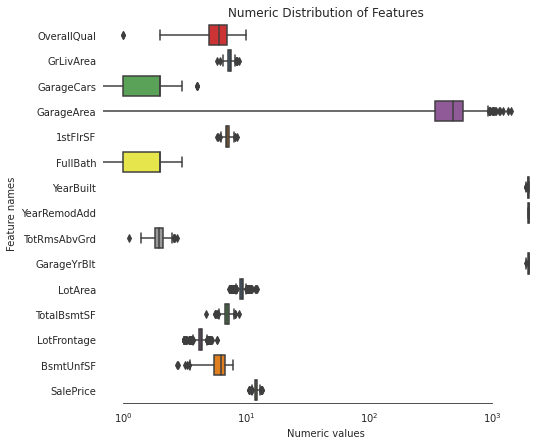

In [ ]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=x_train_numeric_final_saleprice, orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

From the box plots, we are not able to visualize completely, hence we plot the distribution of each variable and check for outliers manually. We could do this with a formula of IQR or Z score, but since from the data exploration stage earlier, we were able to catch some outliers right away.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

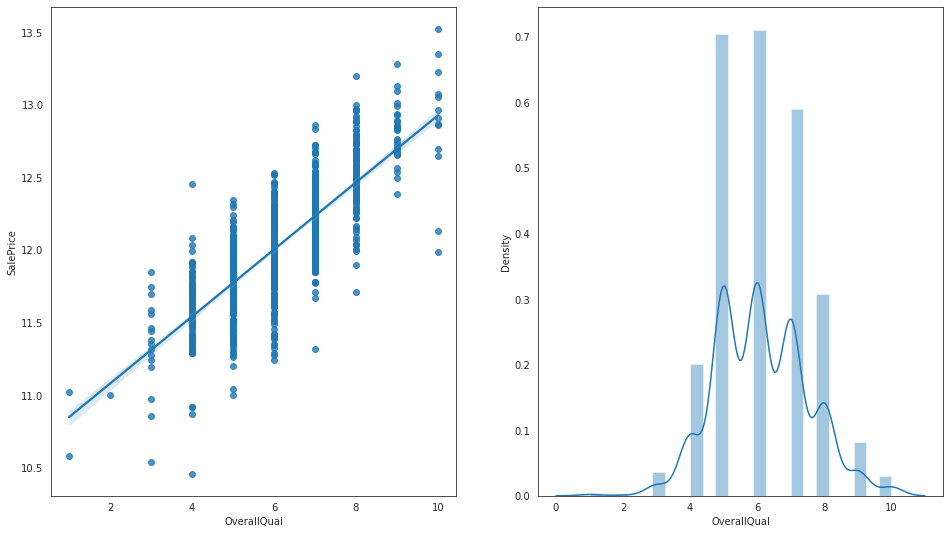

In [ ]:
# Create a scatterplot to visualize better
plt.figure(figsize=(16, 9))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
sns.regplot(x='OverallQual', y='SalePrice', data=x_train_numeric_final_saleprice, ax=axes[0])
sns.distplot(x_train_numeric_final_saleprice['OverallQual'], ax=axes[1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

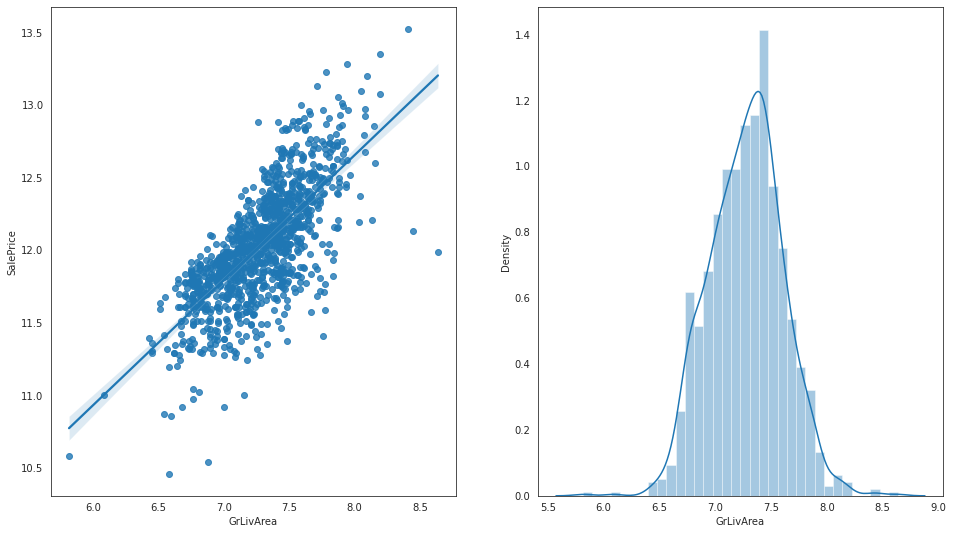

In [ ]:
# Create a scatterplot to visualize better
plt.figure(figsize=(16, 9))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
sns.regplot(x='GrLivArea', y='SalePrice', data=x_train_numeric_final_saleprice, ax=axes[0])
sns.distplot(x_train_numeric_final_saleprice['GrLivArea'], ax=axes[1])

In [ ]:
x_train_numeric_final_saleprice.sort_values(by = 'GrLivArea', ascending = False)[:5]

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF,SalePrice
1298,10,8.638171,2,1418,8.453827,2,2008,2008,2.564949,2008.0,11.064887,8.717846,5.749393,6.146329,11.982935
523,10,8.450412,3,884,8.051660,3,2007,2008,2.484907,2007.0,10.599007,8.051660,4.875197,6.778785,12.126764
1182,10,8.406708,3,813,7.788212,3,1996,1996,2.397895,1996.0,9.656563,7.781973,5.081404,5.707110,13.521141
1169,10,8.196437,3,807,7.513164,3,1995,1996,2.397895,1995.0,10.484613,7.565793,4.779123,6.298949,13.345509
185,10,8.191186,3,840,7.325808,2,1892,1993,2.564949,1993.0,10.041117,7.010312,4.510860,7.010312,13.071072


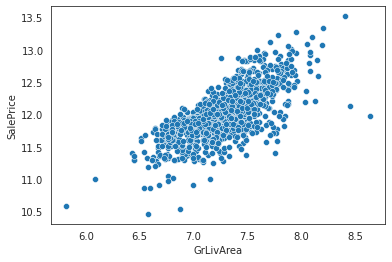

In [ ]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=x_train_numeric_final_saleprice)

In [ ]:
# Delete the first two observations from the end
x_train_numeric_final_saleprice = x_train_numeric_final_saleprice.drop(1298)
x_train_numeric_final_saleprice = x_train_numeric_final_saleprice.drop(523)

x_train_numeric_final_saleprice.sort_values(by = 'GrLivArea', ascending = False)[:5]

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF,SalePrice
1182,10,8.406708,3,813,7.788212,3,1996,1996,2.397895,1996.0,9.656563,7.781973,5.081404,5.707110,13.521141
1169,10,8.196437,3,807,7.513164,3,1995,1996,2.397895,1995.0,10.484613,7.565793,4.779123,6.298949,13.345509
185,10,8.191186,3,840,7.325808,2,1892,1993,2.564949,1993.0,10.041117,7.010312,4.510860,7.010312,13.071072
304,7,8.158802,3,870,7.424165,3,1880,2002,2.397895,2003.0,9.819399,7.293698,4.477337,7.293698,12.594734
1268,8,8.145550,3,1014,7.585281,3,1935,1997,2.484907,1982.0,9.554001,6.591674,4.262680,6.285998,12.850557


In [ ]:
x_train_df_obj = x_train_df_obj.drop(1298)
x_train_df_obj = x_train_df_obj.drop(523)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

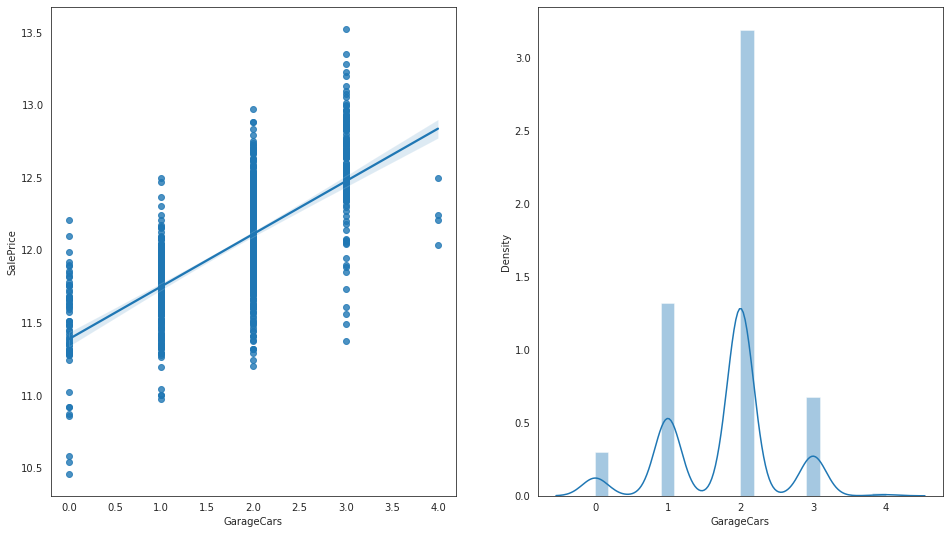

In [ ]:
# Create a scatterplot to visualize better
plt.figure(figsize=(16, 9))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
sns.regplot(x='GarageCars', y='SalePrice', data=x_train_numeric_final_saleprice, ax=axes[0])
sns.distplot(x_train_numeric_final_saleprice['GarageCars'], ax=axes[1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

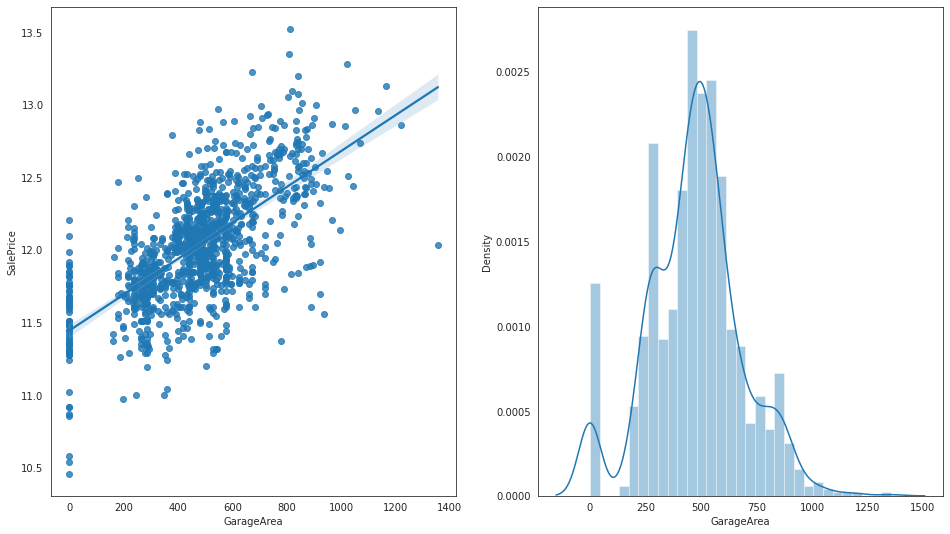

In [ ]:
# Create a scatterplot to visualize better
plt.figure(figsize=(16, 9))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
sns.regplot(x='GarageArea', y='SalePrice', data=x_train_numeric_final_saleprice, ax=axes[0])
sns.distplot(x_train_numeric_final_saleprice['GarageArea'], ax=axes[1])

In [ ]:
x_train_numeric_final_saleprice.sort_values(by = 'GarageArea', ascending = False)[:5]

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF,SalePrice
1190,4,7.392032,4,1356,7.392032,1,1961,1975,2.079442,1975.0,10.387887,7.130899,4.262680,4.510860,12.031725
825,10,7.642524,3,1220,7.642524,2,2007,2008,2.079442,2007.0,9.602653,7.639642,4.744932,6.093570,12.861001
178,9,7.711997,3,1166,7.711997,2,2008,2009,2.302585,2009.0,9.765604,7.703910,4.158883,5.746203,13.126033
664,8,7.648740,3,1134,7.648740,1,2005,2006,2.197225,2005.0,9.947361,7.639161,3.912023,5.877736,12.955130
1417,8,7.804251,3,1069,7.178545,2,1998,1998,2.079442,1998.0,9.713900,7.158514,4.262680,6.222576,12.736704


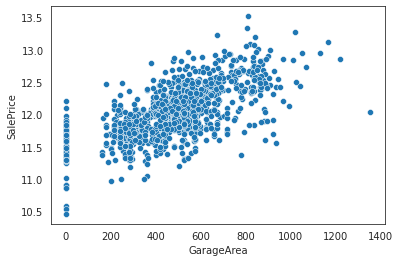

In [ ]:
sns.scatterplot(x='GarageArea', y='SalePrice', data=x_train_numeric_final_saleprice)

In [ ]:
# Delete the first two observations from the end
# x_train_numeric_final_saleprice = x_train_numeric_final_saleprice.drop(1061)
x_train_numeric_final_saleprice = x_train_numeric_final_saleprice.drop(1190)

x_train_numeric_final_saleprice.sort_values(by = 'GarageArea', ascending = False)[:5]

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF,SalePrice
825,10,7.642524,3,1220,7.642524,2,2007,2008,2.079442,2007.0,9.602653,7.639642,4.744932,6.093570,12.861001
178,9,7.711997,3,1166,7.711997,2,2008,2009,2.302585,2009.0,9.765604,7.703910,4.158883,5.746203,13.126033
664,8,7.648740,3,1134,7.648740,1,2005,2006,2.197225,2005.0,9.947361,7.639161,3.912023,5.877736,12.955130
1417,8,7.804251,3,1069,7.178545,2,1998,1998,2.079442,1998.0,9.713900,7.158514,4.262680,6.222576,12.736704
1142,8,7.947679,3,1052,7.290975,3,2006,2007,2.484907,2006.0,9.206935,7.290975,4.356709,5.758902,12.959541


In [ ]:
# x_train_df_obj = x_train_df_obj.drop(1061)
x_train_df_obj = x_train_df_obj.drop(1190)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

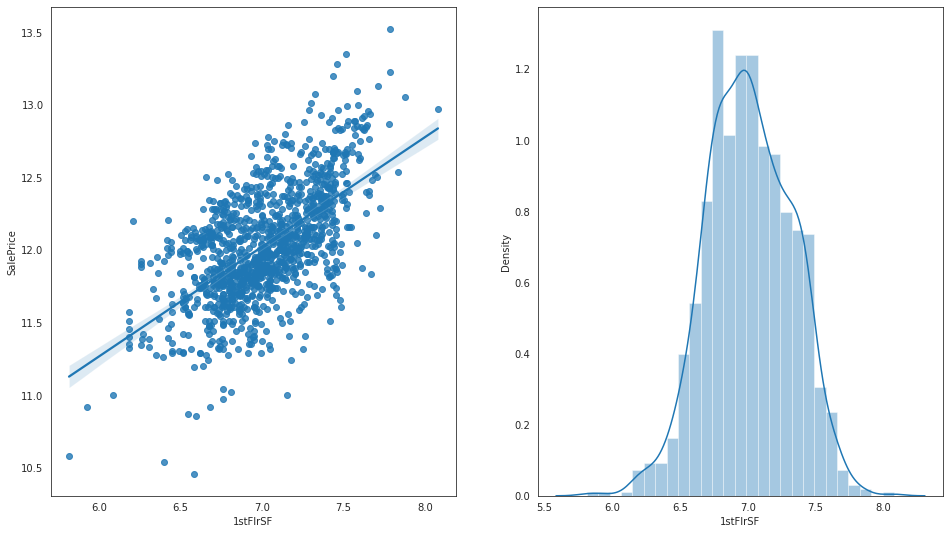

In [ ]:
# Create a scatterplot to visualize better
plt.figure(figsize=(16, 9))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
sns.regplot(x='1stFlrSF', y='SalePrice', data=x_train_numeric_final_saleprice, ax=axes[0])
sns.distplot(x_train_numeric_final_saleprice['1stFlrSF'], ax=axes[1])

In [ ]:
x_train_numeric_final_saleprice.sort_values(by = '1stFlrSF', ascending = False)[:5]

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF,SalePrice
496,8,8.079928,2,546,8.079928,3,1992,1993,2.397895,1992.0,9.448806,8.071219,4.262680,7.585789,12.971543
1373,10,7.876259,3,804,7.876259,2,2001,2002,2.197225,2001.0,9.341456,7.876259,4.262680,7.209340,13.053015
1044,8,7.833996,2,542,7.833996,2,1981,1981,2.302585,1981.0,9.169623,7.833996,4.394449,7.259116,12.535380
1182,10,8.406708,3,813,7.788212,3,1996,1996,2.397895,1996.0,9.656563,7.781973,5.081404,5.707110,13.521141
440,10,7.784473,3,672,7.784473,2,2008,2008,2.397895,2008.0,9.644199,8.037543,4.663439,6.670766,13.226725


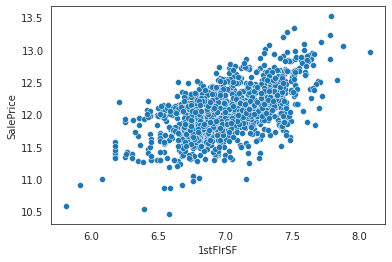

In [ ]:
sns.scatterplot(x='1stFlrSF', y='SalePrice', data=x_train_numeric_final_saleprice)

No outliers from the scatterplot

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

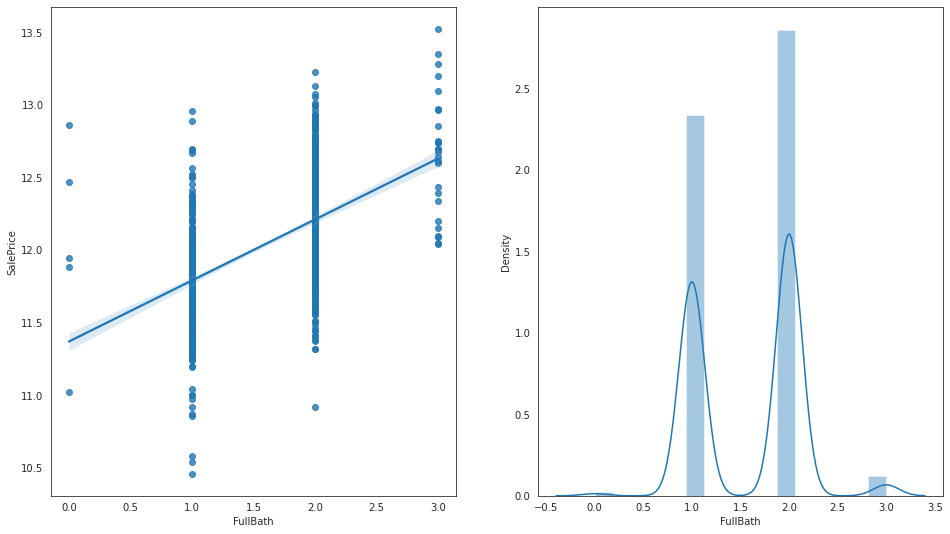

In [ ]:
# Create a scatterplot to visualize better
plt.figure(figsize=(16, 9))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
sns.regplot(x='FullBath', y='SalePrice', data=x_train_numeric_final_saleprice, ax=axes[0])
sns.distplot(x_train_numeric_final_saleprice['FullBath'], ax=axes[1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

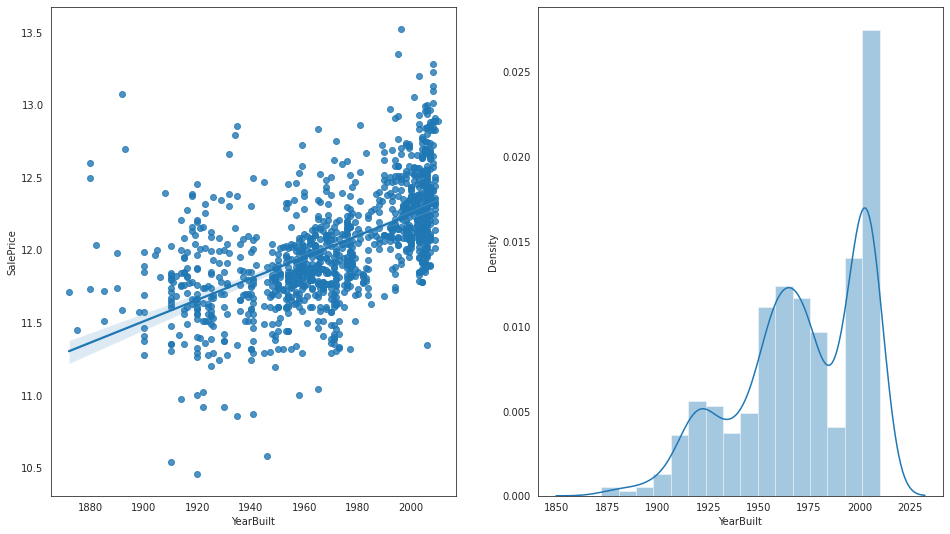

In [ ]:
# Create a scatterplot to visualize better
plt.figure(figsize=(16, 9))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
sns.regplot(x='YearBuilt', y='SalePrice', data=x_train_numeric_final_saleprice, ax=axes[0])
sns.distplot(x_train_numeric_final_saleprice['YearBuilt'], ax=axes[1])

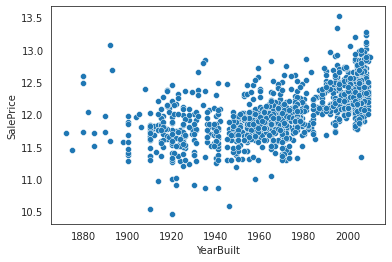

In [ ]:
sns.scatterplot(x='YearBuilt', y='SalePrice', data=x_train_numeric_final_saleprice)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

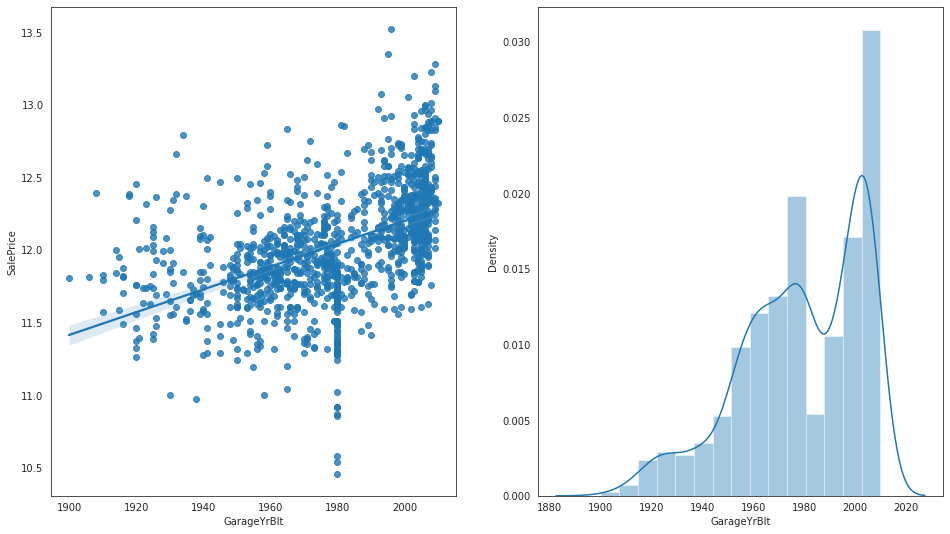

In [ ]:
# Create a scatterplot to visualize better
plt.figure(figsize=(16, 9))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
sns.regplot(x='GarageYrBlt', y='SalePrice', data=x_train_numeric_final_saleprice, ax=axes[0])
sns.distplot(x_train_numeric_final_saleprice['GarageYrBlt'], ax=axes[1])

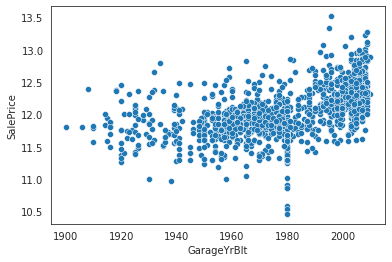

In [ ]:
sns.scatterplot(x='GarageYrBlt', y='SalePrice', data=x_train_numeric_final_saleprice)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

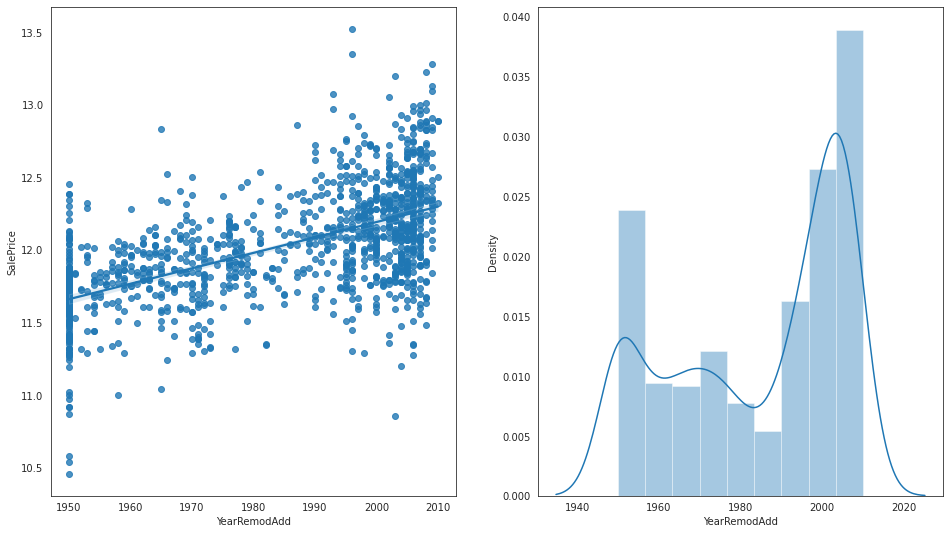

In [ ]:
# Create a scatterplot to visualize better
plt.figure(figsize=(16, 9))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
sns.regplot(x='YearRemodAdd', y='SalePrice', data=x_train_numeric_final_saleprice, ax=axes[0])
sns.distplot(x_train_numeric_final_saleprice['YearRemodAdd'], ax=axes[1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

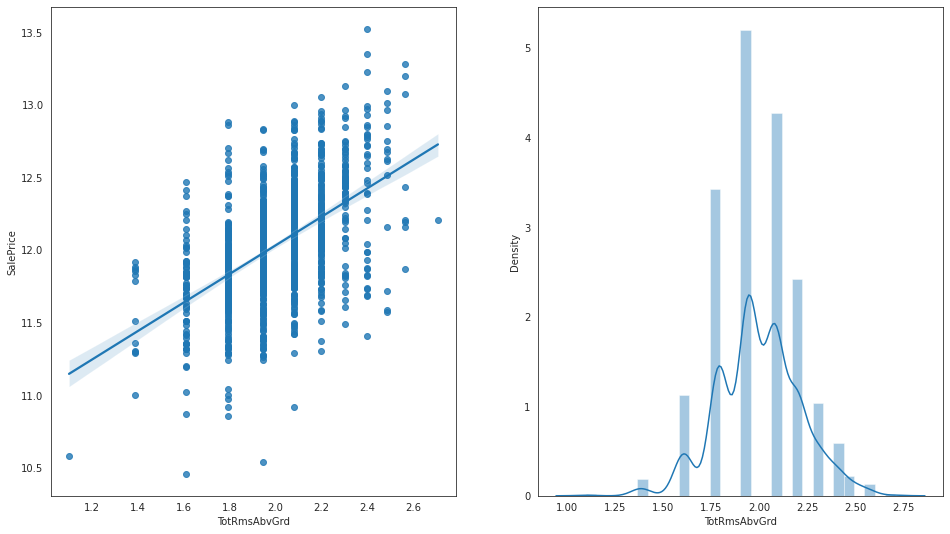

In [ ]:
# Create a scatterplot to visualize better
plt.figure(figsize=(16, 9))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
sns.regplot(x='TotRmsAbvGrd', y='SalePrice', data=x_train_numeric_final_saleprice, ax=axes[0])
sns.distplot(x_train_numeric_final_saleprice['TotRmsAbvGrd'], ax=axes[1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

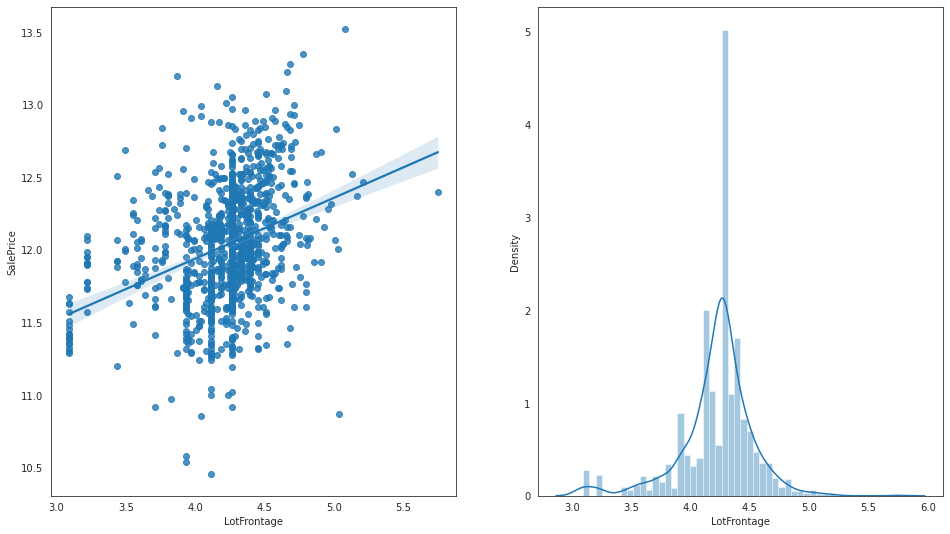

In [ ]:
# Create a scatterplot to visualize better
plt.figure(figsize=(16, 9))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
sns.regplot(x='LotFrontage', y='SalePrice', data=x_train_numeric_final_saleprice, ax=axes[0])
sns.distplot(x_train_numeric_final_saleprice['LotFrontage'], ax=axes[1])

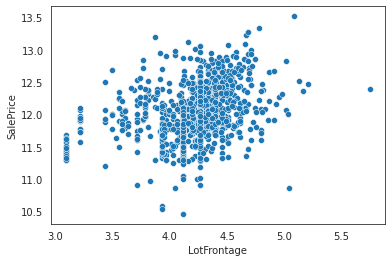

In [ ]:
sns.scatterplot(x='LotFrontage', y='SalePrice', data=x_train_numeric_final_saleprice)

In [ ]:
x_train_numeric_final_saleprice.sort_values(by = 'LotFrontage', ascending = False)[:5]

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF,SalePrice
934,7,7.635304,2,505,7.635304,2,1960,2007,2.302585,1960.0,10.227417,6.373320,5.749393,5.081404,12.396697
1127,7,7.333676,3,630,7.333676,2,2004,2004,2.079442,2004.0,9.586926,7.333676,5.209486,5.442418,12.464587
197,8,8.043342,2,795,7.215975,2,1918,1990,2.197225,1918.0,10.143292,7.215975,5.164786,4.948760,12.367345
1107,7,7.611842,2,422,6.788972,2,2006,2006,2.302585,2006.0,10.054404,6.767343,5.129899,6.767343,12.523530
1182,10,8.406708,3,813,7.788212,3,1996,1996,2.397895,1996.0,9.656563,7.781973,5.081404,5.707110,13.521141


In [ ]:
x_train_numeric_final_saleprice = x_train_numeric_final_saleprice.drop(934)

x_train_numeric_final_saleprice.sort_values(by = 'LotFrontage', ascending = False)[:5]

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF,SalePrice
1127,7,7.333676,3,630,7.333676,2,2004,2004,2.079442,2004.0,9.586926,7.333676,5.209486,5.442418,12.464587
197,8,8.043342,2,795,7.215975,2,1918,1990,2.197225,1918.0,10.143292,7.215975,5.164786,4.948760,12.367345
1107,7,7.611842,2,422,6.788972,2,2006,2006,2.302585,2006.0,10.054404,6.767343,5.129899,6.767343,12.523530
1182,10,8.406708,3,813,7.788212,3,1996,1996,2.397895,1996.0,9.656563,7.781973,5.081404,5.707110,13.521141
1337,4,6.542472,0,0,6.542472,1,1941,1950,1.609438,1980.0,8.323366,6.542472,5.036953,6.542472,10.868587


In [ ]:
x_train_df_obj = x_train_df_obj.drop(934)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

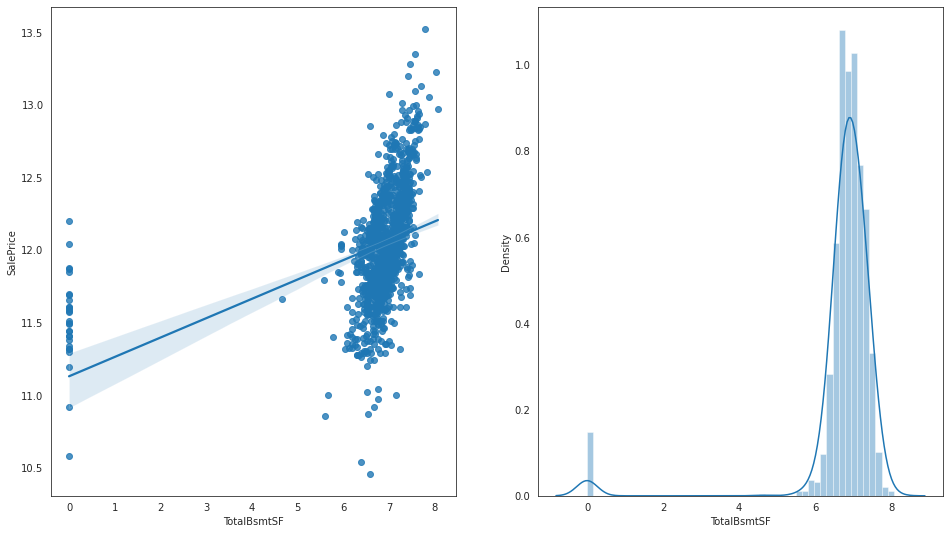

In [ ]:
# Create a scatterplot to visualize better
plt.figure(figsize=(16, 9))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
sns.regplot(x='TotalBsmtSF', y='SalePrice', data=x_train_numeric_final_saleprice, ax=axes[0])
sns.distplot(x_train_numeric_final_saleprice['TotalBsmtSF'], ax=axes[1])

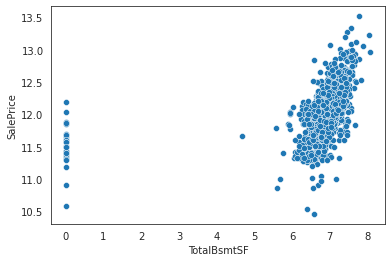

In [ ]:
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=x_train_numeric_final_saleprice)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

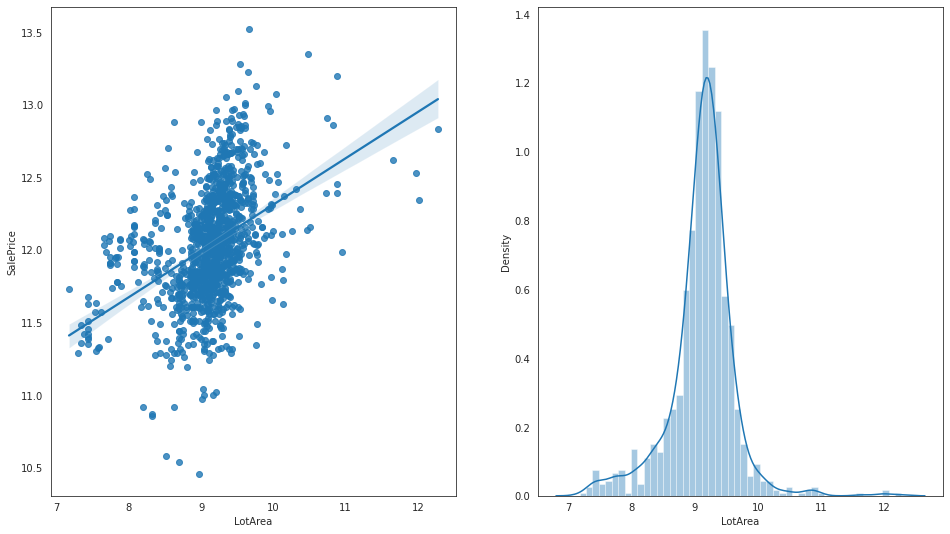

In [ ]:
# Create a scatterplot to visualize better
plt.figure(figsize=(16, 9))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
sns.regplot(x='LotArea', y='SalePrice', data=x_train_numeric_final_saleprice, ax=axes[0])
sns.distplot(x_train_numeric_final_saleprice['LotArea'], ax=axes[1])

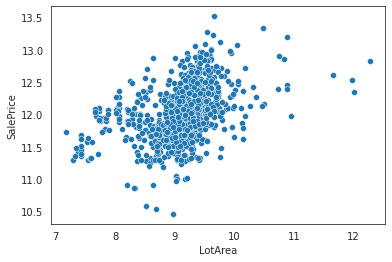

In [ ]:
sns.scatterplot(x='LotArea', y='SalePrice', data=x_train_numeric_final_saleprice)

In [ ]:
x_train_numeric_final_saleprice.sort_values(by = 'LotArea', ascending = False)[:5]

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF,SalePrice
313,7,7.619233,2,513,7.619233,2,1965,1965,2.197225,1965.0,12.279537,7.667158,5.01728,4.394449,12.834684
335,5,7.488294,2,529,7.390181,2,1965,1965,2.079442,1965.0,12.011644,7.313220,4.26268,4.644391,12.341263
249,6,7.670895,2,389,7.275865,2,1958,2006,2.079442,1958.0,11.976666,7.275865,4.26268,6.617403,12.531776
706,7,7.509335,2,739,7.509335,2,1971,2002,1.791759,1971.0,11.653991,7.404888,4.26268,6.052089,12.618186
1396,5,7.431300,2,572,7.431300,1,1948,1950,2.079442,1966.0,10.954327,6.617403,4.26268,4.110874,11.982935


In [ ]:
x_train_numeric_final_saleprice = x_train_numeric_final_saleprice.drop(313)
x_train_numeric_final_saleprice = x_train_numeric_final_saleprice.drop(249)
x_train_numeric_final_saleprice = x_train_numeric_final_saleprice.drop(335)
x_train_numeric_final_saleprice = x_train_numeric_final_saleprice.drop(706)

x_train_numeric_final_saleprice.sort_values(by = 'LotArea', ascending = False)[:5]

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF,SalePrice
1396,5,7.431300,2,572,7.431300,1,1948,1950,2.079442,1966.0,10.954327,6.617403,4.262680,4.110874,11.982935
769,8,8.095599,3,841,7.433075,3,2003,2003,2.564949,2003.0,10.887530,7.409136,3.871201,5.459586,13.195616
457,4,7.416980,2,529,7.416980,1,1954,1994,1.945910,1954.0,10.882340,7.218910,4.262680,5.517453,12.452937
384,6,7.577634,2,501,6.984716,2,1992,1992,2.302585,1992.0,10.880083,7.365813,4.262680,6.390241,12.388398
53,9,7.519150,3,894,7.519150,0,1981,1987,1.791759,1981.0,10.825204,7.519150,4.234107,3.496508,12.861001


In [ ]:
x_train_df_obj = x_train_df_obj.drop(335)
x_train_df_obj = x_train_df_obj.drop(706)
x_train_df_obj = x_train_df_obj.drop(313)
x_train_df_obj = x_train_df_obj.drop(249)



---



In [ ]:
# Let's look at both the numeric and categorical dataframe again

x_train_numeric_final_saleprice['SalePrice']

254     11.884496
1066    12.089544
638     11.350418
799     12.072547
380     11.751950
          ...    
1095    12.080696
1130    11.813037
1294    11.652696
860     12.154521
1126    12.066816
Name: SalePrice, Length: 1160, dtype: float64

In [ ]:
y_train = x_train_numeric_final_saleprice['SalePrice']

In [ ]:
x_train_numeric_final_saleprice.drop(['SalePrice'], axis=1, inplace=True)

In [ ]:
x_train_numeric = x_train_numeric_final_saleprice

In [ ]:
x_train_numeric.shape[0] == y_train.shape[0]

True

In [ ]:
x_train_df_obj.shape[0] == x_train_numeric.shape[0]

True

In [ ]:
x_test_df_numeric_final.shape[1] == x_train_numeric.shape[1]

True

# Get one hot encoding labels for categorical features

We are not going to drop any of the categorical features, since we are not able to see their correlation with SalePrice. Here we will get the one hot encoding labels.

In [ ]:
x_train_df_obj_dummies = pd.get_dummies(x_train_df_obj)
x_train_df_obj_dummies

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,...,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
254,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1066,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
638,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
799,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
380,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1130,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1294,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
860,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
x_test_df_obj_dummies = pd.get_dummies(x_test_df_obj)
x_test_df_obj_dummies

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,...,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
892,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1105,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
413,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
522,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1036,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
1361,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
802,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
651,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
final_train_obj_dummies, final_test_obj_dummies = x_train_df_obj_dummies.align(x_test_df_obj_dummies, join='inner', axis=1)  # inner join

In [ ]:
print(final_train_obj_dummies.shape)
print(final_test_obj_dummies.shape)

(1160, 205)
(292, 205)


- Train set: x_train_numeric + x_train_df_obj_dummies, y_train

- Test set: x_test_df_numeric_final + x_test_df_obj_dummies, y_test

In [ ]:
x_train_numeric

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF
254,5,7.181592,1,294,7.181592,1,1957,1957,1.791759,1957.0,9.036106,7.181592,4.262680,5.973810
1066,6,7.360104,2,380,6.684612,2,1993,1994,2.079442,1993.0,8.966739,6.684612,4.094345,6.684612
638,5,6.680855,0,0,6.680855,1,1910,1950,1.609438,1980.0,9.080004,6.680855,4.219508,6.680855
799,5,7.478170,1,240,6.889591,1,1937,1950,2.079442,1939.0,8.881975,6.595781,4.110874,5.093750
380,5,7.433667,1,308,6.934397,2,1924,1950,1.945910,1924.0,8.517393,6.934397,3.931826,6.695799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,6,7.181592,2,440,7.181592,2,2006,2006,1.945910,2006.0,9.139703,7.181592,4.369448,7.163172
1130,4,7.591862,2,576,7.192182,2,1928,1950,2.079442,1981.0,8.962520,7.023759,4.189655,6.216606
1294,5,6.762730,2,572,6.762730,1,1955,1990,1.791759,1957.0,9.008591,6.762730,4.110874,6.548219
860,7,7.263330,1,216,6.816736,1,1918,1998,2.079442,1925.0,8.941545,6.816736,4.025352,6.816736


In [ ]:
final_train_obj_dummies

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,...,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
254,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1066,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
638,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
799,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
380,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1130,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1294,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
860,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
x_test_df_numeric_final

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF
892,6,6.974479,1,264,6.974479,1,1963,2003,1.945910,1963.0,9.037771,6.966024,4.262680,5.983936
1105,8,7.872074,2,712,7.313887,2,1994,1995,2.302585,1994.0,9.413852,7.288928,4.595120,6.068426
413,5,6.936343,2,360,6.936343,1,1927,1950,1.791759,1927.0,9.100637,6.916715,4.043051,6.916715
522,6,7.417580,2,420,6.912743,2,1947,1950,2.079442,1950.0,8.517393,6.912743,3.931826,6.406880
1036,9,7.390799,3,912,7.390799,2,2007,2008,1.945910,2008.0,9.464905,7.390799,4.499810,6.395262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,4,7.031741,2,672,7.031741,1,1937,2000,2.079442,1995.0,8.687105,6.811244,3.931826,6.606650
1361,7,7.333676,2,430,7.333676,2,2005,2005,2.079442,2005.0,9.690232,7.333676,4.828314,5.549076
802,7,7.284135,2,410,6.591674,2,2005,2005,2.079442,2005.0,9.011889,6.591674,4.158883,4.394449
651,4,7.320527,1,296,6.628041,1,1940,1950,2.079442,1940.0,9.114380,6.628041,4.110874,6.628041


In [ ]:
final_test_obj_dummies

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,...,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
892,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1105,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
413,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
522,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1036,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
1361,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
802,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
651,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
y_train

254     11.884496
1066    12.089544
638     11.350418
799     12.072547
380     11.751950
          ...    
1095    12.080696
1130    11.813037
1294    11.652696
860     12.154521
1126    12.066816
Name: SalePrice, Length: 1160, dtype: float64

In [ ]:
y_test

892     154500
1105    325000
413     115000
522     159000
1036    315500
         ...  
479      89471
1361    260000
802     189000
651     108000
722     124500
Name: SalePrice, Length: 292, dtype: int64

We are also not going to add any new features with feature engineering, mainly because we can see how many features we already have compared to the data points, but we could always do that later. 



---



Regrouping x_train, x_test, y_train, y_test

In [ ]:
x_train = pd.concat([x_train_numeric, final_train_obj_dummies], axis=1)
x_test = pd.concat([x_test_df_numeric_final, final_test_obj_dummies], axis=1)
y_train = y_train
y_test = y_test

In [ ]:
x_train

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,...,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
254,5,7.181592,1,294,7.181592,1,1957,1957,1.791759,1957.0,9.036106,7.181592,4.262680,5.973810,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1066,6,7.360104,2,380,6.684612,2,1993,1994,2.079442,1993.0,8.966739,6.684612,4.094345,6.684612,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
638,5,6.680855,0,0,6.680855,1,1910,1950,1.609438,1980.0,9.080004,6.680855,4.219508,6.680855,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
799,5,7.478170,1,240,6.889591,1,1937,1950,2.079442,1939.0,8.881975,6.595781,4.110874,5.093750,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
380,5,7.433667,1,308,6.934397,2,1924,1950,1.945910,1924.0,8.517393,6.934397,3.931826,6.695799,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,6,7.181592,2,440,7.181592,2,2006,2006,1.945910,2006.0,9.139703,7.181592,4.369448,7.163172,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1130,4,7.591862,2,576,7.192182,2,1928,1950,2.079442,1981.0,8.962520,7.023759,4.189655,6.216606,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1294,5,6.762730,2,572,6.762730,1,1955,1990,1.791759,1957.0,9.008591,6.762730,4.110874,6.548219,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
860,7,7.263330,1,216,6.816736,1,1918,1998,2.079442,1925.0,8.941545,6.816736,4.025352,6.816736,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
is_NaN = x_train.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = x_train[row_has_NaN]
rows_with_NaN

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,...,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial


In [ ]:
is_NaN = x_test.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = x_test[row_has_NaN]
rows_with_NaN

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,...,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial


In [ ]:
y_train.isnull().sum()
# row_has_NaN = is_NaN.any(axis=1)
# rows_with_NaN = y_train[row_has_NaN]
# rows_with_NaN

0

In [ ]:
y_test.isnull().sum()

0

# Standard Scaler

In [ ]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Modelling

Here, we go for Lasso, Ridge and Linear regression without cross-validation first, then perform cross-validation on a number of regressors such as:
- ridge
- lasso 
- elasticnet
- random forest regressor
- support vector regressor
- gradient boosting regressor
- light gradient boosting machine (lgbm)
- xgboost regressor


In [ ]:
def rmse(yt, yp):
  return np.sqrt(mean_squared_error(yt, yp))

In [ ]:
def mae(yt, yp):
  return mean_absolute_error(yt, yp)

In [ ]:
def mse(yt, yp):
  return mean_squared_error(yt, yp)

In [ ]:
def cv_rmse(model, X = x_train, y = y_train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv = kfolds))
    return rmse

In [ ]:
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

1. Lasso

In [ ]:
lasso_predictor = Lasso(max_iter=100000, normalize=True)
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)

lassocv.fit(x_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=100000, n_alphas=100, n_jobs=None, normalize=True,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [ ]:
lasso_predictor.set_params(alpha=lassocv.alpha_)
lasso_predictor.fit(x_train, y_train)

Lasso(alpha=0.00010027293955793432, copy_X=True, fit_intercept=True,
      max_iter=100000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
y_pred_lasso = lasso_predictor.predict(x_test)
exp_y_pred_lasso = np.expm1(y_pred_lasso)

In [ ]:
print("Alpha: ", lassocv.alpha_)
print("RMSE: ", rmse(y_test, exp_y_pred_lasso))
print("MAE: ", mae(y_test, exp_y_pred_lasso))
print("MSE: ", mse(y_test, exp_y_pred_lasso))
print("R2: ", r2_score(y_test, exp_y_pred_lasso))

Alpha:  0.00010027293955793432
RMSE:  24244.31400940121
MAE:  15457.031701825335
MSE:  587786761.7864476
R2:  0.9233687400106023


2. Ridge

In [ ]:
alphas = np.geomspace(1e-9, 5, num=100)

ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(x_train, y_train)

ridge_predictor = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge_predictor.fit(x_train, y_train)

y_pred_ridge = ridge_predictor.predict(x_test)
exp_y_pred_ridge = np.expm1(y_pred_ridge)

print('Ridge Regression:')
print("Alpha =", ridgecv.alpha_)
print("RMSE: ", rmse(y_test, exp_y_pred_ridge))
print("MAE: ", mae(y_test, exp_y_pred_ridge))
print("MSE: ", mse(y_test, exp_y_pred_ridge))
print("R2: ", r2_score(y_test, exp_y_pred_ridge))

Ridge Regression:
Alpha = 0.0862027087008591
RMSE:  24193.760590274156
MAE:  15978.970779201769
MSE:  585338051.4995029
R2:  0.9236879846190845


3. Linear Regression

In [ ]:
lr = LinearRegression()

lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)
exp_y_pred_lr = np.expm1(y_pred_lr)

print('Linear Regression:')
print("RMSE: ", rmse(y_test, exp_y_pred_lr))
print("MAE: ", mae(y_test, exp_y_pred_lr))
print("MSE: ", mse(y_test, exp_y_pred_lr))
print("R2: ", r2_score(y_test, exp_y_pred_lr))

Linear Regression:
RMSE:  31386.232968537963
MAE:  17418.529267727226
MSE:  985095619.9553394
R2:  0.8715705703582332


Others

In [ ]:
ridge = make_pipeline(RobustScaler(), RidgeCV())
lasso = make_pipeline(RobustScaler(), LassoCV())
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV())
rf = RandomForestRegressor()
svr = SVR()
gbr = GradientBoostingRegressor()
lightgbm = LGBMRegressor()
xgboost = XGBRegressor()

In [ ]:
models = [ridge, lasso, elasticnet, rf, svr, gbr, lightgbm, xgboost]
mean = []
std = []
for model in models:
    mean.append(cv_rmse(model).mean())
    std.append(cv_rmse(model).std())

models_df = pd.DataFrame({'Model': ['Ridge', 'Lasso', 'Elastic Net', 'Random Forest', 'SVR', 'Gradient Boosting', 'Light GBM', 'XGBoost'],
                         'Mean': mean, 'Std': std})
models_df.sort_values(by = 'Mean', inplace = True, ignore_index = True)

[09:03:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
models_df

,Model,Mean,Std
0,Lasso,0.114953,0.012487
1,Elastic Net,0.114997,0.012438
2,Ridge,0.122720,0.014877
3,Gradient Boosting,0.129247,0.013522
4,XGBoost,0.130378,0.012262
5,Light GBM,0.134407,0.015178
6,Random Forest,0.142775,0.013951
7,SVR,0.189021,0.018192


# Pipeline for test.csv

1. Split the test set into int, float and dtype (or however many dtypes the test dataset has)
2. Impute test set (int or float) with median of train set; test set (obj) with mode of train set
3. Concatenate test set (int and float) and log transform to fix skewness
4. Select the features from the train set and remove others in the test set
5. Get dummies for test set (obj) and align with train set
6. Combine the numerical dataframe with categorical dataframe
7. Make predictions

In [ ]:
test_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,Comp

In [ ]:
train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,G

In [ ]:
# Split the train set into the three dtypes
train_int = train_df.select_dtypes(include='int64', exclude=['float64', 'object'])
train_float = train_df.select_dtypes(include='float64', exclude=['int64', 'object'])
train_obj = train_df.select_dtypes(include='object', exclude=['int64', 'float64'])

In [ ]:
# Split the test set into the three dtypes
test_int = test_df.select_dtypes(include='int64', exclude=['float64', 'object'])
test_float = test_df.select_dtypes(include='float64', exclude=['int64', 'object'])
test_obj = test_df.select_dtypes(include='object', exclude=['int64', 'float64'])

In [ ]:
# Impute the test set numerical features with the median of the train set
train_numeric = pd.concat([train_int, train_float], axis=1)
train_numeric.drop(['SalePrice'], axis=1, inplace=True)

test_numeric = pd.concat([test_int, test_float], axis=1)
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(train_numeric)

test_numeric_transformed = imp_median.transform(test_numeric)

In [ ]:
test_numeric = pd.DataFrame(test_numeric_transformed, columns = test_numeric.columns)

In [ ]:
test_numeric.isnull().sum()

Id               0
MSSubClass       0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
LotFrontage      0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
BsmtFullBath     0
BsmtHalfBath     0
GarageYrBlt      0
GarageCars       0
GarageArea       0
dtype: int64

In [ ]:
# Impute the missing values of the test set object dtypes with the most frequent values/mode of the train set
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mode.fit(train_obj)

test_obj_transformed = imp_mode.transform(test_obj)

In [ ]:
test_obj = pd.DataFrame(test_obj_transformed, columns = test_obj.columns)

In [ ]:
test_obj.isnull().sum()

MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
dtype: int64

Here we apply log transformation to the features in test set that we have applied in the train set.

In [ ]:
skew_index

Index(['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF',
       'KitchenAbvGr', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath',
       'EnclosedPorch', 'LotFrontage', 'OpenPorchSF', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', 'WoodDeckSF', 'MSSubClass', 'GrLivArea',
       '1stFlrSF', 'BsmtUnfSF', '2ndFlrSF', 'OverallCond', 'TotRmsAbvGrd',
       'HalfBath', 'Fireplaces', 'BsmtFullBath'],
      dtype='object')

In [ ]:
# Apply the log transformation to the features we have concluded to be skewed in the train set
for i in skew_index:
  test_numeric[i] = np.log1p(test_numeric[i])

In [ ]:
test_numeric

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
0,1461.0,3.044522,9.360741,5.0,1.945910,1961.0,1961.0,6.799056,0.000000,0.0,6.799056,1.0,0.000000,2.0,0.693147,1.791759,0.000000,4.948760,0.000000,0.0,0.0,4.795791,0.0,0.000000,6.0,2010.0,4.394449,0.000000,6.150603,4.976734,5.602119,6.783325,0.000000,0.000000,1961.0,1.0,730.0
1,1462.0,3.044522,9.565775,6.0,1.945910,1958.0,1958.0,7.192934,0.000000,0.0,7.192934,1.0,0.693147,3.0,0.693147,1.945910,0.000000,5.976351,3.610918,0.0,0.0,0.000000,0.0,9.433564,6.0,2010.0,4.406719,4.691348,6.828712,0.000000,6.008813,7.192934,0.000000,0.000000,1958.0,1.0,312.0
2,1463.0,4.110874,9.534668,5.0,1.791759,1997.0,1998.0,6.834109,6.553933,0.0,7.396335,2.0,0.693147,3.0,0.693147,1.945910,0.693147,5.361292,3.555348,0.0,0.0,0.000000,0.0,0.000000,3.0,2010.0,4.317488,0.000000,6.674561,0.000000,4.927254,6.834109,0.000000,0.000000,1997.0,2.0,482.0
3,1464.0,4.110874,9.208238,6.0,1.945910,1998.0,1998.0,6.831954,6.520621,0.0,7.380879,2.0,0.693147,3.0,0.693147,2.079442,0.693147,5.888878,3.610918,0.0,0.0,0.000000,0.0,0.000000,6.0,2010.0,4.369448,3.044522,6.401917,0.000000,5.783825,6.831954,0.000000,0.000000,1998.0,2.0,470.0
4,1465.0,4.795791,8.518392,8.0,1.791759,1992.0,1992.0,7.155396,0.000000,0.0,7.155396,2.0,0.000000,2.0,0.693147,1.791759,0.000000,0.000000,4.418841,0.0,0.0,4.976734,0.0,0.000000,1.0,2010.0,3.784190,0.000000,5.575949,0.000000,6.925595,7.155396,0.000000,0.000000,1992.0,2.0,506.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915.0,5.081404,7.568896,4.0,2.079442,1970.0,1970.0,6.304449,6.304449,0.0,6.996681,1.0,0.693147,3.0,0.693147,1.791759,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,6.0,2006.0,3.091042,0.000000,0.000000,0.000000,6.304449,6.304449,0.000000,0.000000,69.0,0.0,0.0
1455,2916.0,5.081404,7.546974,4.0,1.791759,1970.0,1970.0,6.304449,6.304449,0.0,6.996681,1.0,0.693147,3.0,0.693147,1.945910,0.000000,0.000000,3.218876,0.0,0.0,0.000000,0.0,0.000000,4.0,2006.0,3.091042,0.000000,5.533389,0.000000,5.686975,6.304449,0.000000,0.000000,1970.0,1.0,286.0
1456,2917.0,3.044522,9.903538,5.0,2.079442,1960.0,1996.0,7.110696,0.000000,0.0,7.110696,1.0,0.000000,4.0,0.693147,2.079442,0.693147,6.163315,0.000000,0.0,0.0,0.000000,0.0,0.000000,9.0,2006.0,5.081404,0.000000,7.110696,0.000000,0.000000,7.110696,0.693147,0.000000,1960.0,2.0,576.0
1457,2918.0,4.454347,9.253591,5.0,1.791759,1992.0,1992.0,6.878326,0.000000,0.0,6.878326,1.0,0.000000,3.0,0.693147,1.945910,0.000000,4.394449,3.496508,0.0,0.0,0.000000,0.0,6.552508,7.0,2006.0,4.143135,0.000000,5.823046,0.000000,6.356108,6.816736,0.000000,0.693147,69.0,0.0,0.0


In [ ]:
selected_features

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 '1stFlrSF',
 'FullBath',
 'YearBuilt',
 'YearRemodAdd',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'LotArea',
 'TotalBsmtSF',
 'LotFrontage',
 'BsmtUnfSF']

In [ ]:
# Obtain only the selected features that we have chosen from the train set
test_numeric_final = test_numeric[selected_features]
test_numeric_final

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF
0,5.0,6.799056,1.0,730.0,6.799056,1.0,1961.0,1961.0,1.791759,1961.0,9.360741,6.783325,4.394449,5.602119
1,6.0,7.192934,1.0,312.0,7.192934,1.0,1958.0,1958.0,1.945910,1958.0,9.565775,7.192934,4.406719,6.008813
2,5.0,7.396335,2.0,482.0,6.834109,2.0,1997.0,1998.0,1.945910,1997.0,9.534668,6.834109,4.317488,4.927254
3,6.0,7.380879,2.0,470.0,6.831954,2.0,1998.0,1998.0,2.079442,1998.0,9.208238,6.831954,4.369448,5.783825
4,8.0,7.155396,2.0,506.0,7.155396,2.0,1992.0,1992.0,1.791759,1992.0,8.518392,7.155396,3.784190,6.925595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4.0,6.996681,0.0,0.0,6.304449,1.0,1970.0,1970.0,1.791759,69.0,7.568896,6.304449,3.091042,6.304449
1455,4.0,6.996681,1.0,286.0,6.304449,1.0,1970.0,1970.0,1.945910,1970.0,7.546974,6.304449,3.091042,5.686975
1456,5.0,7.110696,2.0,576.0,7.110696,1.0,1960.0,1996.0,2.079442,1960.0,9.903538,7.110696,5.081404,0.000000
1457,5.0,6.878326,0.0,0.0,6.878326,1.0,1992.0,1992.0,1.945910,69.0,9.253591,6.816736,4.143135,6.356108


Here we need to get the one hot encoding labels and align with the train set in order to preserve the number of features

In [ ]:
# Get the dummy variables for the categorical features and align with the train set
test_obj_dummies = pd.get_dummies(test_obj)
_, final_test_obj_dummies = final_train_obj_dummies.align(test_obj_dummies, join='left', axis=1)  # inner join

In [ ]:
final_test_obj_dummies

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,...,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,NaN,0,NaN,0,1,0,0,NaN,0,1,0,NaN,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,NaN,0,NaN,0,1,0,0,NaN,0,1,0,NaN,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,NaN,1,NaN,0,0,0,0,NaN,0,1,0,NaN,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,NaN,1,NaN,0,0,0,0,NaN,0,1,0,NaN,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,NaN,0,NaN,1,0,0,0,NaN,0,1,0,NaN,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,NaN,0,NaN,0,1,0,0,NaN,0,1,0,NaN,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1455,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,NaN,0,NaN,0,1,0,0,NaN,0,1,0,NaN,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
1456,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,NaN,0,NaN,0,1,0,0,NaN,0,1,0,NaN,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
1457,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,NaN,0,NaN,0,1,0,0,NaN,0,1,0,NaN,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
# Fill the missing values of those with NaN
final_test_obj_dummies.fillna(0, inplace=True)

In [ ]:
# Check if there are missing values
final_test_obj_dummies.isnull().sum().max()

0

In [ ]:
# Combine both the numerical and categorical features into one dataframe
final_test = pd.concat([test_numeric_final, final_test_obj_dummies], axis=1)

In [ ]:
final_test

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,LotArea,TotalBsmtSF,LotFrontage,BsmtUnfSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,...,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,5.0,6.799056,1.0,730.0,6.799056,1.0,1961.0,1961.0,1.791759,1961.0,9.360741,6.783325,4.394449,5.602119,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0.0,0,0.0,0,1,0,0,0.0,0,1,0,0.0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1,6.0,7.192934,1.0,312.0,7.192934,1.0,1958.0,1958.0,1.945910,1958.0,9.565775,7.192934,4.406719,6.008813,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0.0,0,0.0,0,1,0,0,0.0,0,1,0,0.0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
2,5.0,7.396335,2.0,482.0,6.834109,2.0,1997.0,1998.0,1.945910,1997.0,9.534668,6.834109,4.317488,4.927254,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0.0,1,0.0,0,0,0,0,0.0,0,1,0,0.0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,6.0,7.380879,2.0,470.0,6.831954,2.0,1998.0,1998.0,2.079442,1998.0,9.208238,6.831954,4.369448,5.783825,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0.0,1,0.0,0,0,0,0,0.0,0,1,0,0.0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
4,8.0,7.155396,2.0,506.0,7.155396,2.0,1992.0,1992.0,1.791759,1992.0,8.518392,7.155396,3.784190,6.925595,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0.0,0,0.0,1,0,0,0,0.0,0,1,0,0.0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4.0,6.996681,0.0,0.0,6.304449,1.0,1970.0,1970.0,1.791759,69.0,7.568896,6.304449,3.091042,6.304449,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0.0,0,0.0,0,1,0,0,0.0,0,1,0,0.0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1455,4.0,6.996681,1.0,286.0,6.304449,1.0,1970.0,1970.0,1.945910,1970.0,7.546974,6.304449,3.091042,5.686975,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0.0,0,0.0,0,1,0,0,0.0,0,1,0,0.0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
1456,5.0,7.110696,2.0,576.0,7.110696,1.0,1960.0,1996.0,2.079442,1960.0,9.903538,7.110696,5.081404,0.000000,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0.0,0,0.0,0,1,0,0,0.0,0,1,0,0.0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
1457,5.0,6.878326,0.0,0.0,6.878326,1.0,1992.0,1992.0,1.945910,69.0,9.253591,6.816736,4.143135,6.356108,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0.0,0,0.0,0,1,0,0,0.0,0,1,0,0.0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
final_test = sc.transform(final_test)

In [ ]:
final_test = pd.DataFrame(final_test)
final_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218
0,-0.820427,-1.462556,-1.052948,1.231487,-0.676329,-1.051824,-0.323598,-1.150408,-0.982479,-0.737760,0.525047,0.022842,0.581263,-0.030600,-0.058824,-0.218808,8.736895,-1.937550,-0.417240,-0.050921,0.050921,-0.714435,-0.173768,-0.072106,0.770329,-0.203206,-0.171118,-0.13904,0.308825,0.029374,-0.482422,-0.275802,-0.184033,-0.050921,0.646601,0.220963,-0.210011,-0.065795,-0.114457,-0.029374,...,-0.088427,-0.058824,-0.157274,-0.160128,-0.106461,0.279405,0.829759,-0.118262,-0.259147,-0.077917,-0.601251,-0.241649,-0.564076,-0.241649,-0.639904,1.192356,-0.178965,-0.106461,-0.241649,-0.041559,0.336517,-0.154371,-0.241649,-0.065795,0.31877,-0.259147,-0.148413,0.303774,-0.178965,-0.077917,-0.058824,-0.058824,-0.298667,-0.041559,0.391256,-0.266644,-0.077917,-0.125546,0.459191,-0.300376
1,-0.084959,-0.250000,-1.052948,-0.780080,0.586226,-1.051824,-0.421242,-1.295124,-0.252779,-0.862428,0.950211,0.388973,0.621253,0.189781,-0.058824,-0.218808,-0.114457,0.516116,-0.417240,-0.050921,0.050921,1.399708,-0.173768,-0.072106,-1.298147,-0.203206,-0.171118,-0.13904,0.308825,0.029374,2.072873,-0.275802,-0.184033,-0.050921,-1.546549,0.220963,-0.210011,-0.065795,-0.114457,-0.029374,...,-0.088427,-0.058824,-0.157274,-0.160128,-0.106461,0.279405,0.829759,-0.118262,-0.259147,-0.077917,-0.601251,-0.241649,-0.564076,-0.241649,-0.639904,1.192356,-0.178965,-0.106461,-0.241649,-0.041559,0.336517,-0.154371,-0.241649,-0.065795,0.31877,-0.259147,-0.148413,0.303774,-0.178965,-0.077917,-0.058824,-0.058824,-0.298667,-0.041559,0.391256,-0.266644,-0.077917,-0.125546,0.459191,-0.300376
2,-0.820427,0.376171,0.301176,0.038022,-0.563969,0.780182,0.848123,0.634421,-0.252779,0.758251,0.885707,0.068235,0.330436,-0.396298,-0.058824,-0.218808,-0.114457,0.516116,-0.417240,-0.050921,0.050921,1.399708,-0.173768,-0.072106,-1.298147,-0.203206,-0.171118,-0.13904,0.308825,0.029374,-0.482422,-0.275802,-0.184033,-0.050921,0.646601,0.220963,-0.210011,-0.065795,-0.114457,-0.029374,...,-0.088427,-0.058824,-0.157274,-0.160128,-0.106461,0.279405,0.829759,-0.118262,-0.259147,-0.077917,-0.601251,-0.241649,1.772811,-0.241649,-0.639904,-0.838676,-0.178965,-0.106461,-0.241649,-0.041559,0.336517,-0.154371,-0.241649,-0.065795,0.31877,-0.259147,-0.148413,0.303774,-0.178965,-0.077917,-0.058824,-0.058824,-0.298667,-0.041559,0.391256,-0.266644,-0.077917,-0.125546,0.459191,-0.300376
3,-0.084959,0.328589,0.301176,-0.019727,-0.570877,0.780182,0.880671,0.634421,0.379316,0.799807,0.208812,0.066309,0.499780,0.067864,-0.058824,-0.218808,-0.114457,0.516116,-0.417240,-0.050921,0.050921,1.399708,-0.173768,-0.072106,-1.298147,-0.203206,-0.171118,-0.13904,0.308825,0.029374,-0.482422,-0.275802,-0.184033,-0.050921,0.646601,0.220963,-0.210011,-0.065795,-0.114457,-0.029374,...,-0.088427,-0.058824,-0.157274,-0.160128,-0.106461,0.279405,0.829759,-0.118262,-0.259147,-0.077917,-0.601251,-0.241649,1.772811,-0.241649,-0.639904,-0.838676,-0.178965,-0.106461,-0.241649,-0.041559,0.336517,-0.154371,-0.241649,-0.065795,0.31877,-0.259147,-0.148413,0.303774,-0.178965,-0.077917,-0.058824,-0.058824,-0.298667,-0.041559,0.391256,-0.266644,-0.077917,-0.125546,0.459191,-0.300376
4,1.385977,-0.365560,0.301176,0.153518,0.465900,0.780182,0.685384,0.344989,-0.982479,0.550472,-1.221676,0.355420,-1.407664,0.686570,-0.058824,-0.218808,-0.114457,0.516116,-0.417240,-0.050921,0.050921,1.399708,-0.173768,-0.072106,-1.298147,-0.203206,5.843930,-0.13904,-3.238078,0.029374,-0.482422,-0.275802,-0.184033,-0.050921,0.646601,0.220963,-0.210011,-0.065795,-0.114457,-0.029374,...,-0.088427,-0.058824,-0.157274,-0.160128,-0.106461,0.279405,0.829759,-0.118262,-0.259147,-0.077917,-0.601251,-0.241649,-0.564076,-0.241649,1.562734,-0.838676,-0.178965,-0.106461,-0.241649,-0.041559,0.336517,-0.15

Here we use the Lasso Regressor to predict, since from our training it seems to be the best performer.

In [ ]:
test_pred_ridge = ridge_predictor.predict(final_test)
exp_test_pred_ridge = np.expm1(test_pred_ridge)

In [ ]:
test_pred_ridge

array([11.70387227, 11.99335729, 12.10727835, ..., 11.9631464 ,
       12.19326935, 12.25040217])

In [ ]:
exp_test_pred_ridge

array([121038.50661637, 161676.24110513, 181184.80804426, ...,
       156864.87207201, 197454.66266603, 209064.35084224])

In [ ]:
test_id = test_df['Id']

In [ ]:
# Preparing the submission dataframe
submission = pd.DataFrame({'Id': test_id, 'SalePrice': exp_test_pred_ridge})
submission.head()

,Id,SalePrice
0,1461,121038.506616
1,1462,161676.241105
2,1463,181184.808044
3,1464,190398.702778
4,1465,211534.780846


In [ ]:
# Saving the submission dataframe
submission.to_csv("/content/drive/My Drive/Fusionex Internship/Regression/ridge_submission.csv", index = False)

# Things I Learnt

Regression
1. Never use the test set until after you have trained your model - any EDA is 
to be done on the TRAIN SET ONLY.
	- If given only one dataset, split it in the beginning to a train, validation and test set. The validation set is used for evaluation or model tweaking.
2. Transformations done on the train set should be done also on the test set.
3. Impute numerical features with median when the data is not skewed.
4. The metrics for regression are usually RMSE, MSE, MAE, and R2 score.
5. Perform feature scaling when the features have different scales, since regression usually depends on distance-based algorithms.
6. When detecting outliers, we can make use of a pipeline - *make_pipeline()* from *sklearn*.
7. To streamline the process better, we can add *StandardScaler()/RobustScaler()* into the pipeline.

---------------------------------------------------------------

1. In cases where there are too many features to handle, looking at the correlation(abs) helps to remove unnecessary features. Convert categorical features to numerical with one-hot encoding/label encoding to see their correlation.
2. Not all features of integer data types are numerical features, some could be ordinal features - beware of these features when performing any scaling or transformations.
3. Perform as few transformations to the features as possible.
4. When there are missing values, we usually impute with mean/median/mode depending on the data type of the features. However, if the percentage of missing data is high, imputing may not be a good solution. First, check if the feature is useful(check correlation). Second, check if it is possible to remove the data points altogether instead of imputing them. Take note of "numerical" features like YearBuilt - imputing with median/mean does not sound logical.
5. After throwing away some unnecessary features, check for multicollinearity. Perform feature engineering to select one from the multicorrelated features.
6. We can check for skewness/distribution of features at a much later stage, especially after checking for outliers. If outliers are still present when performing log transformation, the resultant distribution still consists of outliers. Beware of performing log transformation on all "skewed" features. Some do not make sense, like ordinal features. 
7. Skewness threshold
	- between -1 and 1 - highly skewed
	- between -1 and -0.5 or between 1 and 0.5 - moderately skewed
	- between -0.5 and 0.5 - considerably symmetric
8. Plotting the residual graph can help us understand the model better - if it is performing as expected.